# Ames Housing Data Analysis

## Problem Statement

When it comes to owning a home, homeowners want know the value of their house and potential homeowners want to know what to expect. This is apparent since both parties would want to get the best price out of the sale. For homeowners, they want to know what features to focus on when selling their house, and what features should be highlighted in order to make it outstanding from other properties. On the other hand, buyers would want to get a house at a best value, and not end up paying too much for it.

As part of a property listing and pricing platform that connects home buyers and sellers, we were tasked to **predict sale prices of the properties, as well as determine the features that makes a property valuable** and therefore sell at a higher price.

## Dataset

In this analysis, we will be using the Ames Housing Data Set which contains information from the Ames Assessor’s Office used in computing the value of individual residential properties sold in Ames, Iowa from 2006 to 2010. The Ames Housing dataset was compiled by Dean De Cock for use in data science education.

The data set contains 2930 observations and 82 variables consisting of 23 nominal, 23 ordinal, 14 discrete and 20 continuous variables which can be found here: [data dictionary.](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

Of these variables, property size evidently affects sale price; other factors commonly associated with sale price included access to amenities, location, number of rooms, age and condition of the property. 

## Exploratory Data Analysis and Preprocessing
---

<a id='setup'></a>
### Setup
<a id='lib_imports'></a>
#### Library imports

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='data_imports'></a>
#### Data imports

In [2]:
sample = pd.read_csv('../datasets/sample_sub_reg.csv')

In [3]:
sample.head()

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217
2,6,181479.1217
3,7,181479.1217
4,17,181479.1217


##### Read train dataset

In [4]:
train = pd.read_csv('../datasets/train.csv')

In [5]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [7]:
train.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


##### Read test dataset

In [8]:
test = pd.read_csv('../datasets/test.csv')

In [9]:
test.transpose()

,0,1,2,3,4,5,6,7,8,9,...,869,870,871,872,873,874,875,876,877,878
Id,2658,2718,2414,1989,625,333,1327,858,95,1568,...,337,2765,1746,368,2806,1662,1234,1373,1672,1939
PID,902301120,905108090,528218130,902207150,535105100,923228370,902427150,907202130,533208090,914476010,...,923276250,906426090,528231010,527254020,907401050,527377110,535126140,904100040,527425140,535327160
MS SubClass,190,90,60,30,20,160,20,20,160,20,...,90,20,20,20,20,60,60,20,20,20
MS Zoning,RM,RL,RL,RM,RL,RM,RM,RL,FV,RL,...,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL
Lot Frontage,69,NaN,58,60,NaN,21,52,NaN,39,75,...,70,NaN,182,80,70,80,90,55,60,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Misc Feature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Shed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Misc Val,0,0,0,0,0,0,0,0,0,0,...,600,0,0,0,0,0,0,0,0,0
Mo Sold,4,8,9,7,7,6,5,10,1,2,...,2,6,11,7,3,11,8,8,5,3
Yr Sold,2006,2006,2006,2007,2009,2010,2008,2009,2010,2008,...,2010,2006,2007,2009,2006,2007,2008,2008,2007,2007


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   PID              879 non-null    int64  
 2   MS SubClass      879 non-null    int64  
 3   MS Zoning        879 non-null    object 
 4   Lot Frontage     719 non-null    float64
 5   Lot Area         879 non-null    int64  
 6   Street           879 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        879 non-null    object 
 9   Land Contour     879 non-null    object 
 10  Utilities        879 non-null    object 
 11  Lot Config       879 non-null    object 
 12  Land Slope       879 non-null    object 
 13  Neighborhood     879 non-null    object 
 14  Condition 1      879 non-null    object 
 15  Condition 2      879 non-null    object 
 16  Bldg Type        879 non-null    object 
 17  House Style     

In [11]:
test.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
count,879.000000,8.790000e+02,879.000000,719.000000,879.000000,879.000000,879.000000,879.000000,879.000000,878.000000,...,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000
mean,1445.588168,7.165050e+08,58.270762,69.630042,10340.920364,6.054608,5.565415,1970.533561,1984.444824,106.982916,...,470.832765,93.560865,47.478953,24.037543,2.594994,14.813424,1.882821,48.443686,6.207053,2007.824801
std,850.717105,1.889135e+08,42.211389,23.625372,10047.335167,1.374756,1.128422,30.403527,20.454546,188.356829,...,213.070155,121.174306,69.209179,73.212237,24.948416,52.975963,29.899698,549.858353,2.644097,1.327396
min,2.000000,5.263021e+08,20.000000,21.000000,1477.000000,2.000000,1.000000,1880.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,692.500000,5.284861e+08,20.000000,59.000000,7298.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,...,323.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,1435.000000,5.354542e+08,50.000000,68.000000,9453.000000,6.000000,5.000000,1972.000000,1992.000000,0.000000,...,473.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2197.000000,9.071921e+08,70.000000,80.000000,11606.500000,7.000000,6.000000,2000.000000,2003.000000,173.500000,...,576.000000,171.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2928.000000,1.007100e+09,190.000000,182.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,...,1488.000000,690.000000,742.000000,1012.000000,360.000000,576.000000,555.000000,15500.000000,12.000000,2010.000000


#### Merge dataset

In [12]:
df = pd.concat([train, test], ignore_index=True, sort=False)

In [13]:
df.shape

(2930, 81)

In [14]:
#create backup
df_copy = df.copy()

In [15]:
#Save before changes
df.to_csv('../datasets/df_initial.csv', index=False)

#### Rename columns

In [16]:
#delete spacing in column headers of data
df.columns = [x.replace(" ","") for x in df.columns]

<a id='01'></a>
### Exploratory Data Analysis and Data Cleaning

#### Imputing null values

In [17]:
#Filter out data with null values
df.isnull().sum()[df.isnull().sum() != 0].sort_values(ascending=False)

PoolQC          2917
MiscFeature     2824
Alley           2732
Fence           2358
FireplaceQu     1422
SalePrice        879
LotFrontage      490
GarageYrBlt      159
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      83
BsmtFinType2      81
BsmtCond          80
BsmtQual          80
BsmtFinType1      80
MasVnrType        23
MasVnrArea        23
BsmtHalfBath       2
BsmtFullBath       2
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageArea         1
Electrical         1
dtype: int64

##### PoolQC

**1. PoolQC** refers to Pool quality, which is associated with the value of PoolArea. <br>
Below, we check the PoolArea data associated with null PoolQC values. 

In [18]:
#PoolArea data associated with null PoolQC values
df['PoolArea'][df['PoolQC'].isnull()].sum()

0

Hence, we replace null values in PoolQC with NA since there is no pool.

In [19]:
df['PoolQC'].fillna("NA", inplace=True)

##### MiscFeature

**2. MiscFeature** refers to Miscellaneous feature not covered in other categories. <br> It is associated with the MiscVal variable which is the value of the miscellaneous feature. <br> <br>
There is no null value noted in the associated numerical variable. <br> <br>
Below, we compute the sum of all numerical values in the MiscVal column which is associated with the MiscFeature. <br><br>
Since it is zero, it mostly likely means that there is no MiscFeature of the property. We will replace null values with NA.

In [20]:
#PoolArea data associated with null PoolQC values
df['MiscVal'][df['MiscFeature'].isnull()].sum()

0

In [21]:
df['MiscFeature'].fillna("NA", inplace=True)

##### Alley

**3. Alley** refers to Type of alley access to property. <br>
There is a 'NA' key value in the data dictionary for no alley access but values in the dataset only included 'Grvl' and 'Pave. <br>
The null values are most likely associated with the key "NA" for no alley access. We will replace null values with NA.

In [22]:
df['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [23]:
df['Alley'].fillna("NA", inplace=True)

##### Fence

**4. Fence** refers to fence quality. <br>
There is a 'NA' key value in the data dictionary but values in the dataset only included 'MnPrv', 'GdPrv', 'GdWo' and 'MnWw'. <br>
The null values are most likely associated with the key "NA" for no fence. We will replace null values with NA.

In [24]:
df['Fence'].value_counts()

MnPrv    330
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

In [25]:
df['Fence'].fillna("NA", inplace=True)

##### FireplaceQu

**5. FireplaceQu** refers to Fireplace quality. It is associated with the variable 'Fireplaces' which is the number of fireplaces in the property. <br>
We can do a check if Fireplaces = 0, there is no fireplace in the property. Hence, replace null values with "NA". 


In [26]:
#Fireplaces data associated with null FireplaceQC values
df['Fireplaces'][df['FireplaceQu'].isnull()].sum()

0

In [27]:
df['FireplaceQu'].fillna("NA", inplace=True)
df['FireplaceQu'].isnull().sum()

0

##### LotFrontage

**6. LotFrontage** refers to linear feet of street connected to property. Seems like missing at random; not possible to be zero value. Since data is presumbaly a key variable, we will replace null with average LotFrontage value.

In [28]:
print('LotFrontage average value :' + str(df['LotFrontage'].mean()))
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)

LotFrontage average value :69.22459016393442


##### Garage variables

**7. Garage** associated variables. We noticed that the following variables: `GarageYrBlt`, `GarageCond`, `GarageQual`, `GarageFinish` and `GarageType` coincidentally has similar amount of null values. <br>
It is likely that there is no Garage built. Hence, no descriptive data is input for the following garage variables.  
We will replace null values with "NA" for no garage.

In [29]:
garage_null= ['GarageYrBlt', 'GarageCond', 'GarageQual',
              'GarageFinish' , 'GarageType']

for col in garage_null:
    if col != 'GarageYrBlt':
        df[col].fillna("NA",inplace=True)
    elif col == 'GarageYrBlt':
        df[col].fillna(0,inplace=True)

##### Basement

8. **Basement** associated variables. The following variables contains null values:
`BsmtExposure`, `BsmtFinType2`, `BsmtFinType1`, `BsmtCond`, `BsmtQual`, `BsmtFinSF2`, `BsmtFinSF1`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtHalfBath` and `BsmtFullBath`.

We noticed that the following variables: `BsmtExposure`, `BsmtFinType2`, `BsmtCond` and `BsmtQual` has a similar amount of null values. 

We observe data are mainly in two groups: all null or 0 across the variables, and one null value across the index. 

There seemed to be no basement for data with null or 0 value across the variables which explains no descriptive data keyed into each other variables. We will replace such nulls with "NA" or 0 for no basement.

We also noticed that the remaining data with one null value in either `BsmtExposure` or `BsmtFinType2` is unfinished which is indicated by non-zero value in the `BsmtUnfSF` column. However, for simplicity, we will replace all with NA since the number of missing data is insignificant

In [30]:
bsmt_null = ['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1',
             'BsmtCond','BsmtQual', 'BsmtFinSF2', 
             'BsmtFinSF1','BsmtUnfSF','TotalBsmtSF',
             'BsmtHalfBath', 'BsmtFullBath']
bsmt_null_str = ['BsmtExposure', 'BsmtFinType2',
             'BsmtFinType1', 'BsmtCond','BsmtQual']

bsmt_null_numeric = ['BsmtFinSF2', 
             'BsmtFinSF1','BsmtUnfSF','TotalBsmtSF',
             'BsmtHalfBath', 'BsmtFullBath']

df[bsmt_null][df[bsmt_null].isnull().any(axis=1)].values
#See any null value across variables

array([[nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [nan, nan, nan, nan, nan, 0.0, 0.

In [31]:
# Group 1: Replace null with 0 for numeric types
#since there is no basement
for col in bsmt_null_numeric:
    df[col].fillna(0, inplace=True)


In [32]:
# Group 2: Replace null with NA for non-numeric types
#since there is no basement, or the basement is unfinished
for col in bsmt_null_str:
    df[col].fillna('NA', inplace=True)

##### Other Garage variables

9. **Other Garage** associated variables: GarageCars and GarageArea.
Apparently, the missing values was associated with no Garage, hece, replaced null values with "NA".

In [33]:
garage_null2 = ['GarageCars', 'GarageArea']
pd.set_option('display.max_rows', None)
df[df[garage_null2].isnull().any(axis=1)].transpose()

,1712
Id,2237
PID,910201180
MSSubClass,70
MSZoning,RM
LotFrontage,50
LotArea,9060
Street,Pave
Alley,NA
LotShape,Reg
LandContour,Lvl


In [34]:
#replacing null in columns:
for col in garage_null2:
    df[col].fillna(0, inplace=True)

##### Electrical

10. **Electrical** refers to electrical system of the property. <br>
The sole null value for the variable seemed like it is missing completely at random. <br>
Replace with mode value (i.e. "SBrkr")



In [35]:
df[df['Electrical'].isnull()].T

,2686
Id,1578
PID,916386080
MSSubClass,80
MSZoning,RL
LotFrontage,73
LotArea,9735
Street,Pave
Alley,NA
LotShape,Reg
LandContour,Lvl


In [36]:
#Highest frequency among MSSubClass is SBrkr
df[df['MSSubClass'] == 80].groupby('MSSubClass')['Electrical'].describe()

,count,unique,top,freq
MSSubClass,,,,
80,117,3,SBrkr,114


In [37]:
#Highest frequency among Neighborhood is SBrkr
df[df['Neighborhood'] == 'IDOTRR'].groupby('Neighborhood')['Electrical'].describe()

,count,unique,top,freq
Neighborhood,,,,
IDOTRR,93,5,SBrkr,60


In [38]:
#Highest frequency in SBrkr
df['Electrical'].value_counts()

SBrkr    2682
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [39]:
#Fill null value with SBrkr
df['Electrical'].fillna("SBrkr", inplace=True)

##### Masonry Veneer Variables

11. **Masonry veneer variables** 
It is likely that there is no Masonry veneer, hence replace with "NA" or 0.

In [40]:
#See data where MasVnrArea is null
df[df['MasVnrArea'].isnull()].T

,22,41,86,212,276,338,431,451,591,844,...,1244,1306,1430,1434,1606,1699,1815,1820,1941,2917
Id,2393,2383,539,518,2824,1800,1455,1120,1841,1840,...,485,1752,1185,1128,1096,2261,2456,1728,56,868
PID,528142010,528110050,531371050,528458020,908130020,528458150,907251090,528439010,533208040,533208030,...,528275160,528250010,534104100,528480160,528290090,916384070,528429100,528218010,528240070,907260030
MSSubClass,60,20,20,20,20,60,60,20,120,120,...,60,80,60,60,60,20,20,60,60,60
MSZoning,RL,RL,RL,FV,RL,FV,RL,RL,FV,FV,...,RL,RL,FV,FV,RL,RL,RL,RL,RL,RL
LotFrontage,103,107,67,90,75,112,75,87,35,30,...,69.2246,69.2246,69.2246,65,69.2246,68,49,59,69.2246,70
LotArea,12867,13891,10083,7993,8050,12217,9473,10037,4274,5330,...,12891,11950,7500,8125,7750,8298,15218,15810,7851,8749
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,...,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
Alley,NA,NA,NA,NA,NA,NA,NA,NA,Pave,Pave,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
LotShape,IR1,Reg,Reg,IR1,Reg,IR1,Reg,Reg,IR1,IR2,...,IR1,IR1,Reg,Reg,Reg,IR1,IR1,IR1,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,...,Lvl,Lvl,Lvl,Lvl,Lvl,HLS,Lvl,Lvl,Lvl,Lvl


In [41]:
df['MasVnrType'].fillna("NA", inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

In [42]:
#check nulls
df.isnull().sum()

Id                 0
PID                0
MSSubClass         0
MSZoning           0
LotFrontage        0
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemod/Add      0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea    

#### Outliers

In [43]:
# There seems to be two outliers with a relatively 
# low sale price (below $20,000) for a very large area (4,000 SF).
# Suggest to drop these data

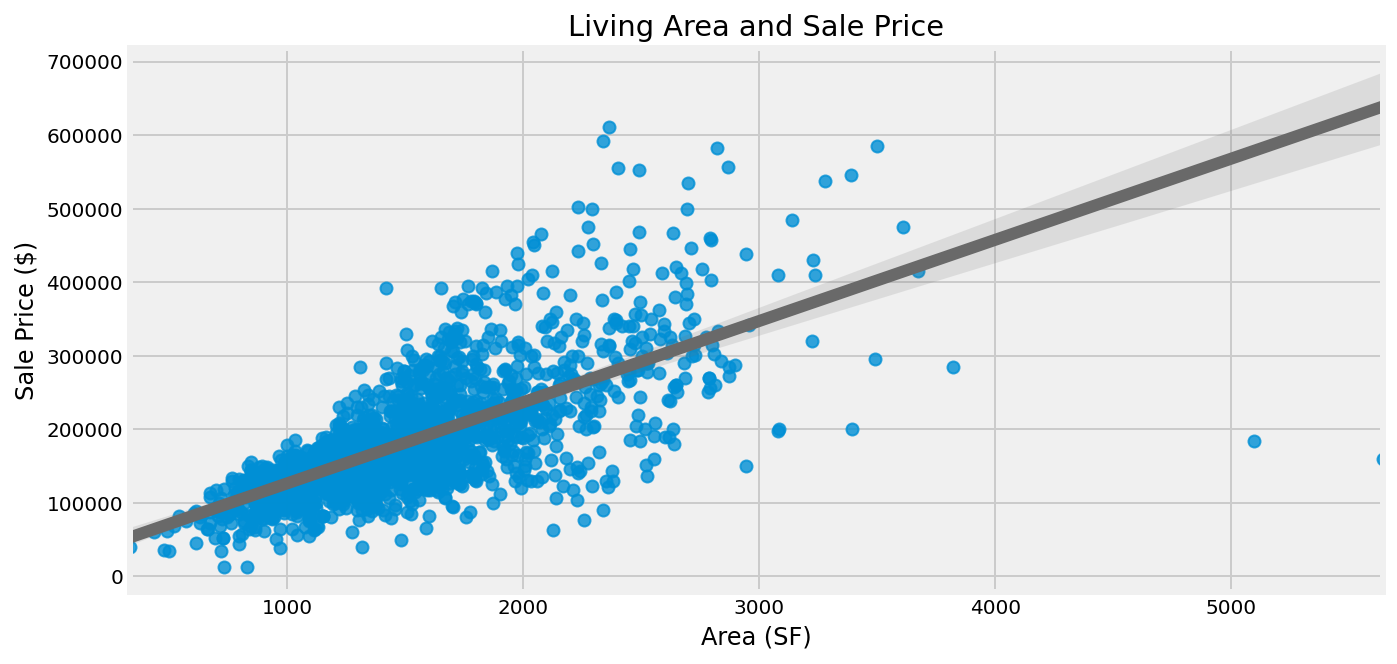

In [44]:
plt.figure(figsize=(10,5))
plt.title('Living Area and Sale Price')
sns.regplot(df['GrLivArea'],df['SalePrice'], line_kws={'color':'dimgrey'});
plt.xlabel('Area (SF)')
plt.ylabel('Sale Price ($)');

In [45]:
df.drop(index=df[(df['GrLivArea'] >4000) & ((df['SalePrice'] < 200000))].index,
        inplace=True)

#### Collinear variables

In [46]:
#TotalBsmtSF is equal to sum of 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'. 
#Since they are collinear, suggest to keep only TotalBsmtSF and drop the rest.
(df['TotalBsmtSF'] == df['BsmtFinSF1'] + 
                        df['BsmtFinSF2'] + 
                         df['BsmtUnfSF']).value_counts()

True    2928
dtype: int64

In [47]:
#drop columns from combined dataframe
df.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1, inplace=True)

#### Sort columns into types

In [48]:
discrete = ['YearBuilt', 'YearRemod/Add', 
            'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
            'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
            'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']
len(discrete)

14

In [49]:
nominal = ['PID', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
          'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
          'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
          'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType', 
          'MiscFeature', 'SaleType']
len(nominal)

23

In [50]:
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual',
          'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
          'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
          'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 
          'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
          'PavedDrive', 'PoolQC', 'Fence'] 
len(ordinal)

23

In [51]:
continuous = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
              'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
              'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
              'PoolArea', 'MiscVal']
len(continuous)

16

**Save dataframe**

In [52]:
#save df again
df.to_csv('../datasets/df_clean')
df_clean = df.copy()

<a id='corr'></a>
### Correlated Variables

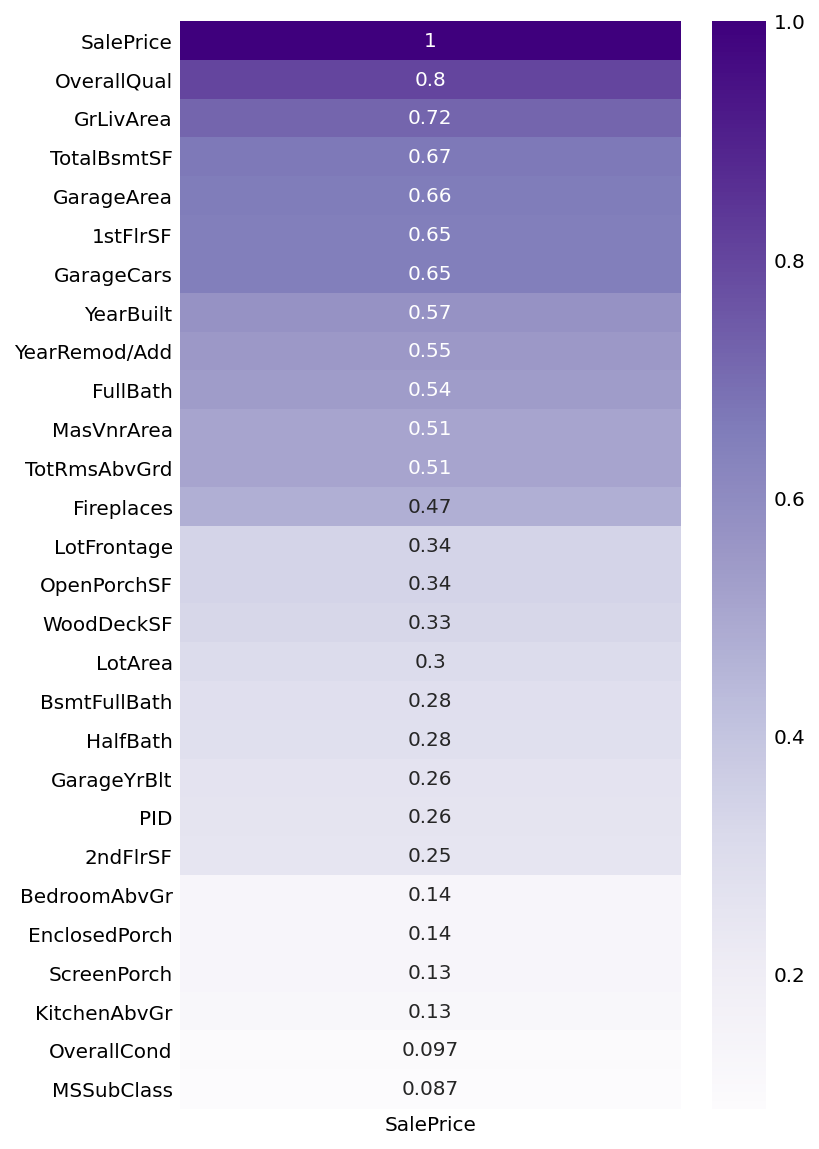

In [53]:
#Correlation of SalePrice and numeric variables
top_corr = np.abs(df.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False)
plt.figure(figsize=(5,10));
sns.heatmap(top_corr.head(28), cmap='Purples', annot=True);


In [54]:
top_corr.head(28).index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea',
       '1stFlrSF', 'GarageCars', 'YearBuilt', 'YearRemod/Add', 'FullBath',
       'MasVnrArea', 'TotRmsAbvGrd', 'Fireplaces', 'LotFrontage',
       'OpenPorchSF', 'WoodDeckSF', 'LotArea', 'BsmtFullBath', 'HalfBath',
       'GarageYrBlt', 'PID', '2ndFlrSF', 'BedroomAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'KitchenAbvGr', 'OverallCond', 'MSSubClass'],
      dtype='object')

In [55]:
pos_corr_feat = top_corr[top_corr['SalePrice'] > 0].index[1:]

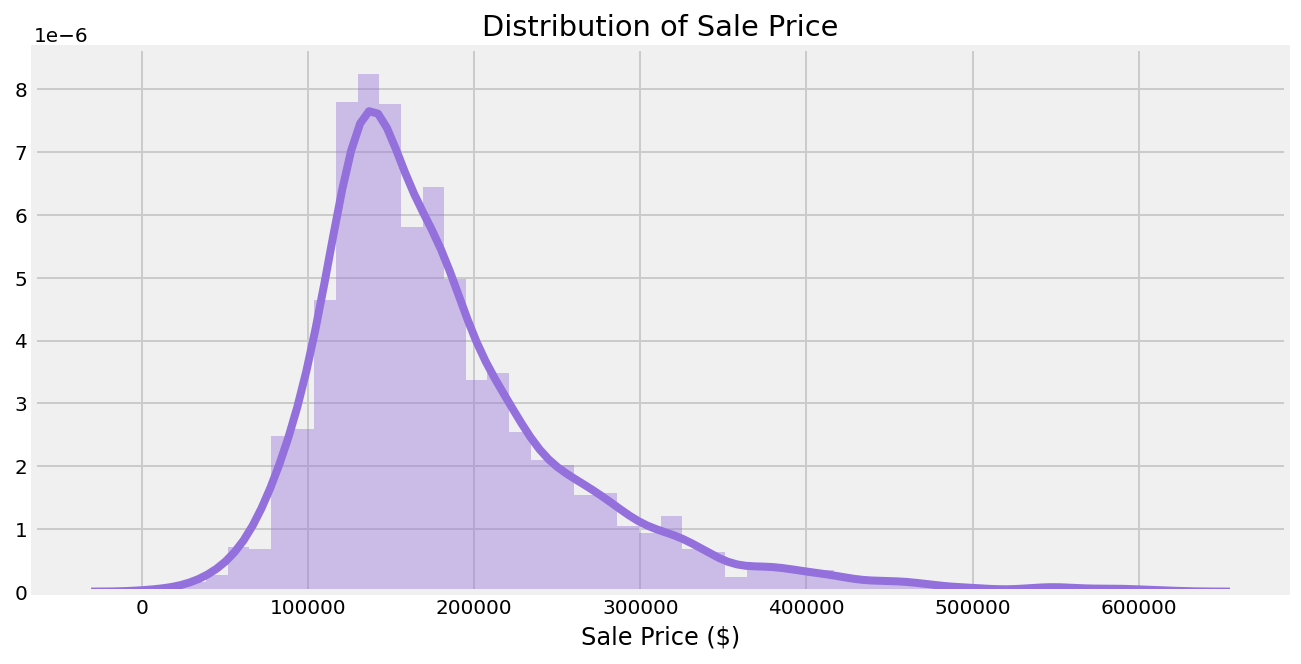

In [56]:
#We can observe that the distribution is skewed and not normal
plt.figure(figsize=(10,5))
plt.title('Distribution of Sale Price')
sns.distplot(df['SalePrice'], color="mediumpurple");
plt.xlabel('Sale Price ($)');

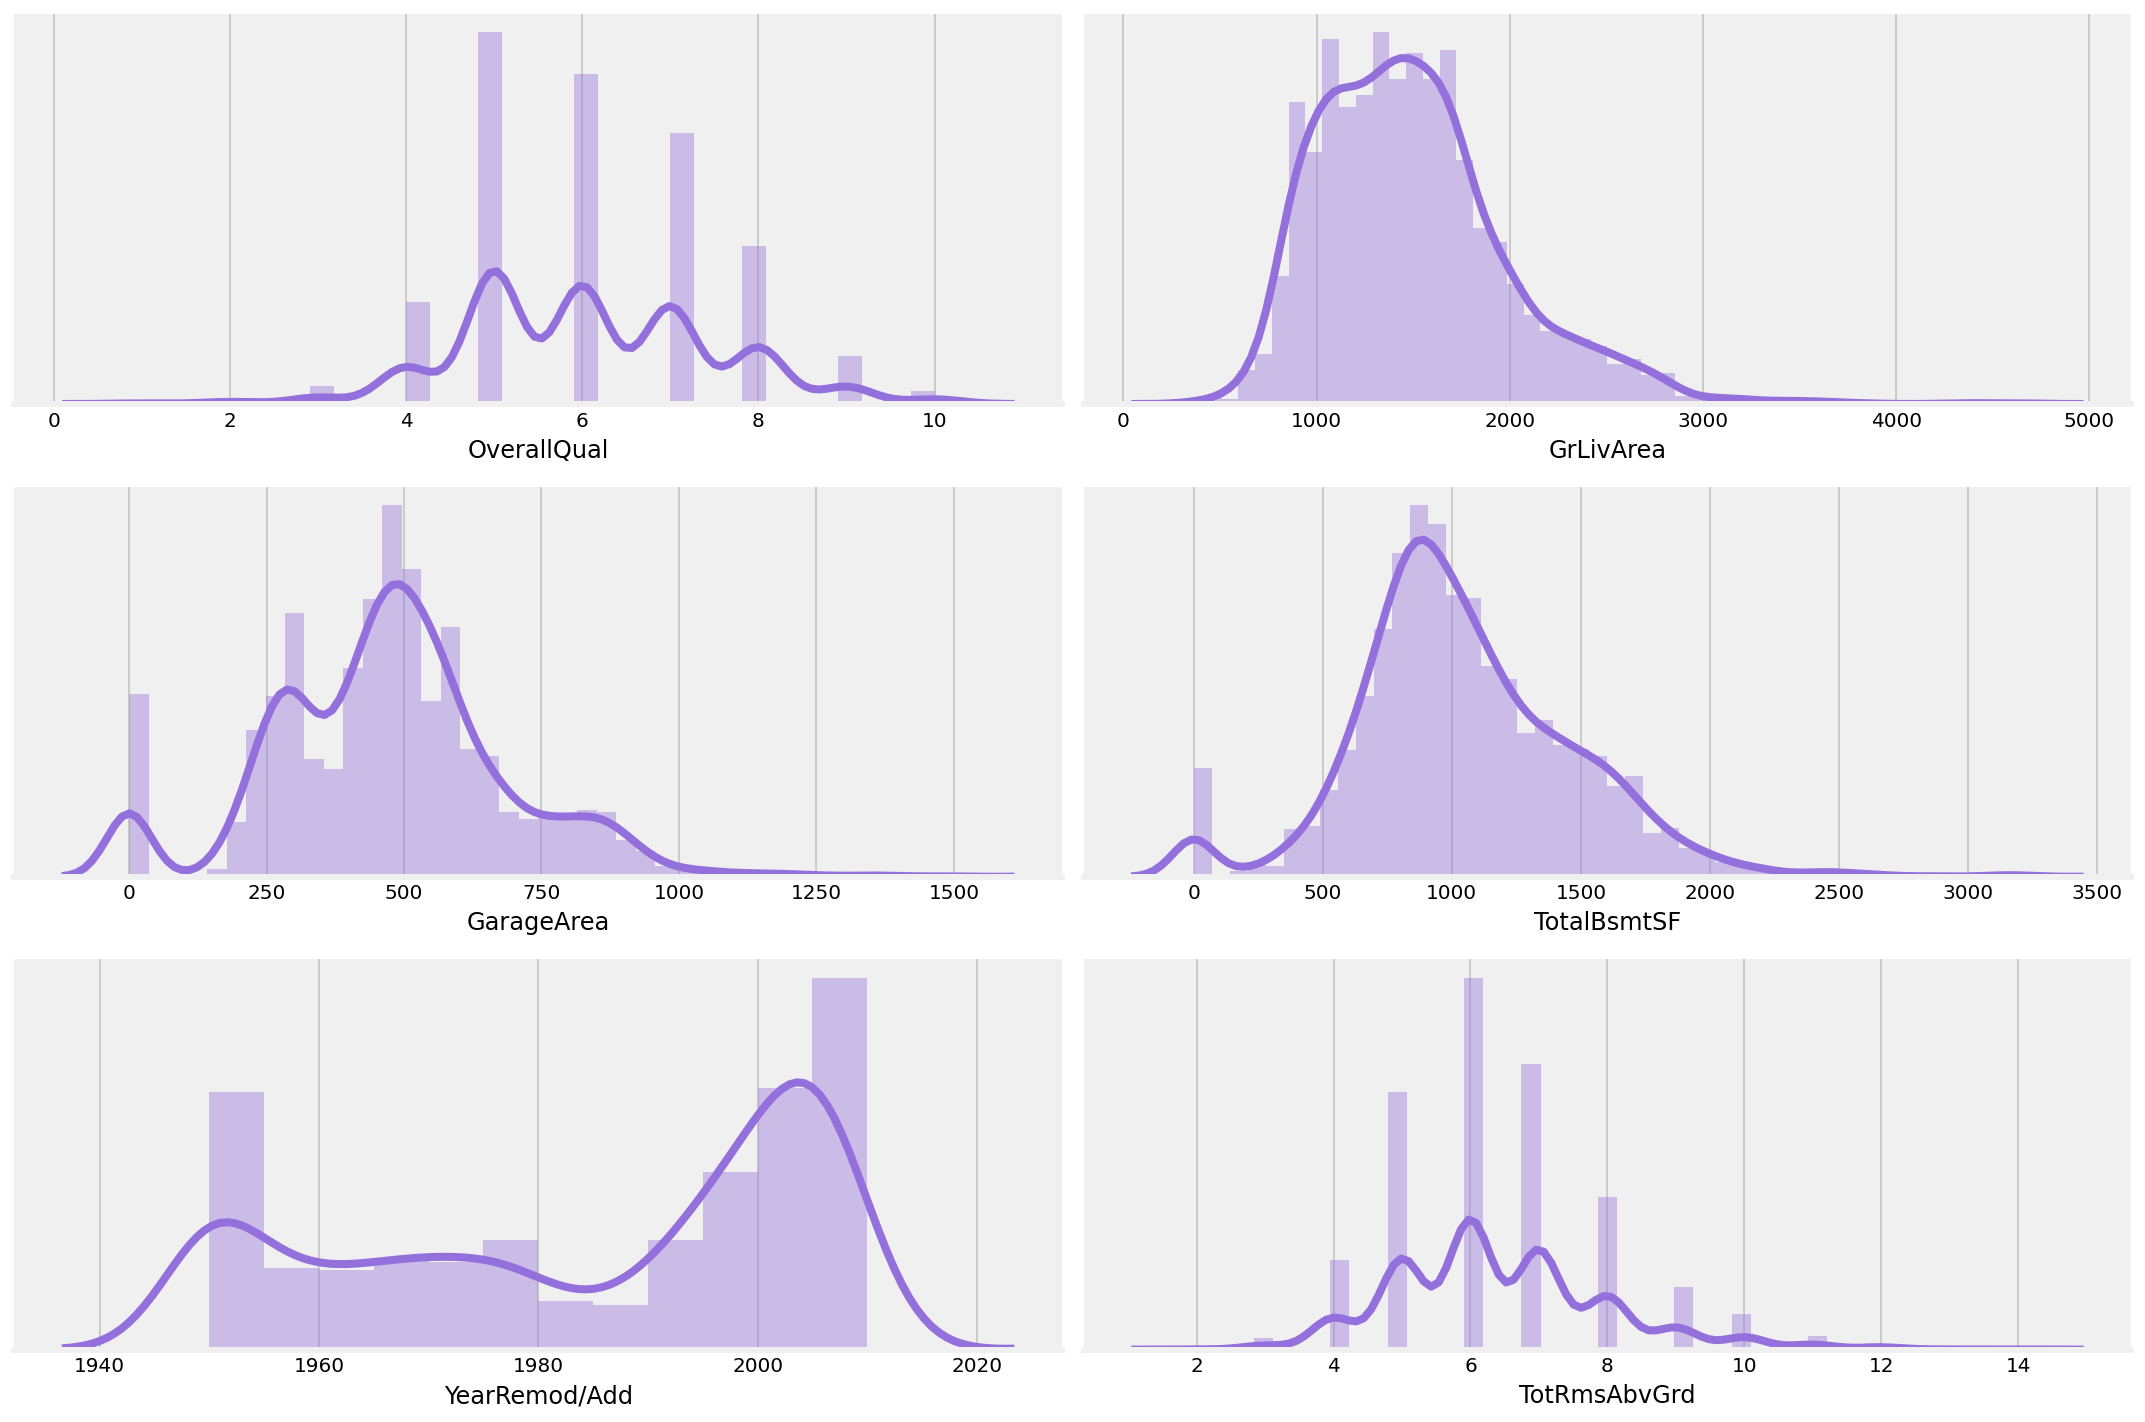

In [57]:
#we will be looking at distributions of a few key variables:
#OverallQual, GrLivArea, GarageArea, TotalBsmtSF, YearRemod/Add, TotRmsAbvGrd
#Most of these distributions are skewed

fig, axes = plt.subplots(3,2, figsize=(15,10))
sns.despine(left=True)

sns.distplot(df['OverallQual'], ax=axes[0, 0], color="mediumpurple")
sns.distplot(df['GrLivArea'], ax=axes[0, 1], color="mediumpurple")
sns.distplot(df['GarageArea'], ax=axes[1, 0], color="mediumpurple")
sns.distplot(df['TotalBsmtSF'], ax=axes[1, 1], color="mediumpurple")
sns.distplot(df['YearRemod/Add'], ax=axes[2, 0], color="mediumpurple")
sns.distplot(df['TotRmsAbvGrd'], ax=axes[2, 1], color="mediumpurple")

plt.setp(axes, yticks=[])
plt.tight_layout();

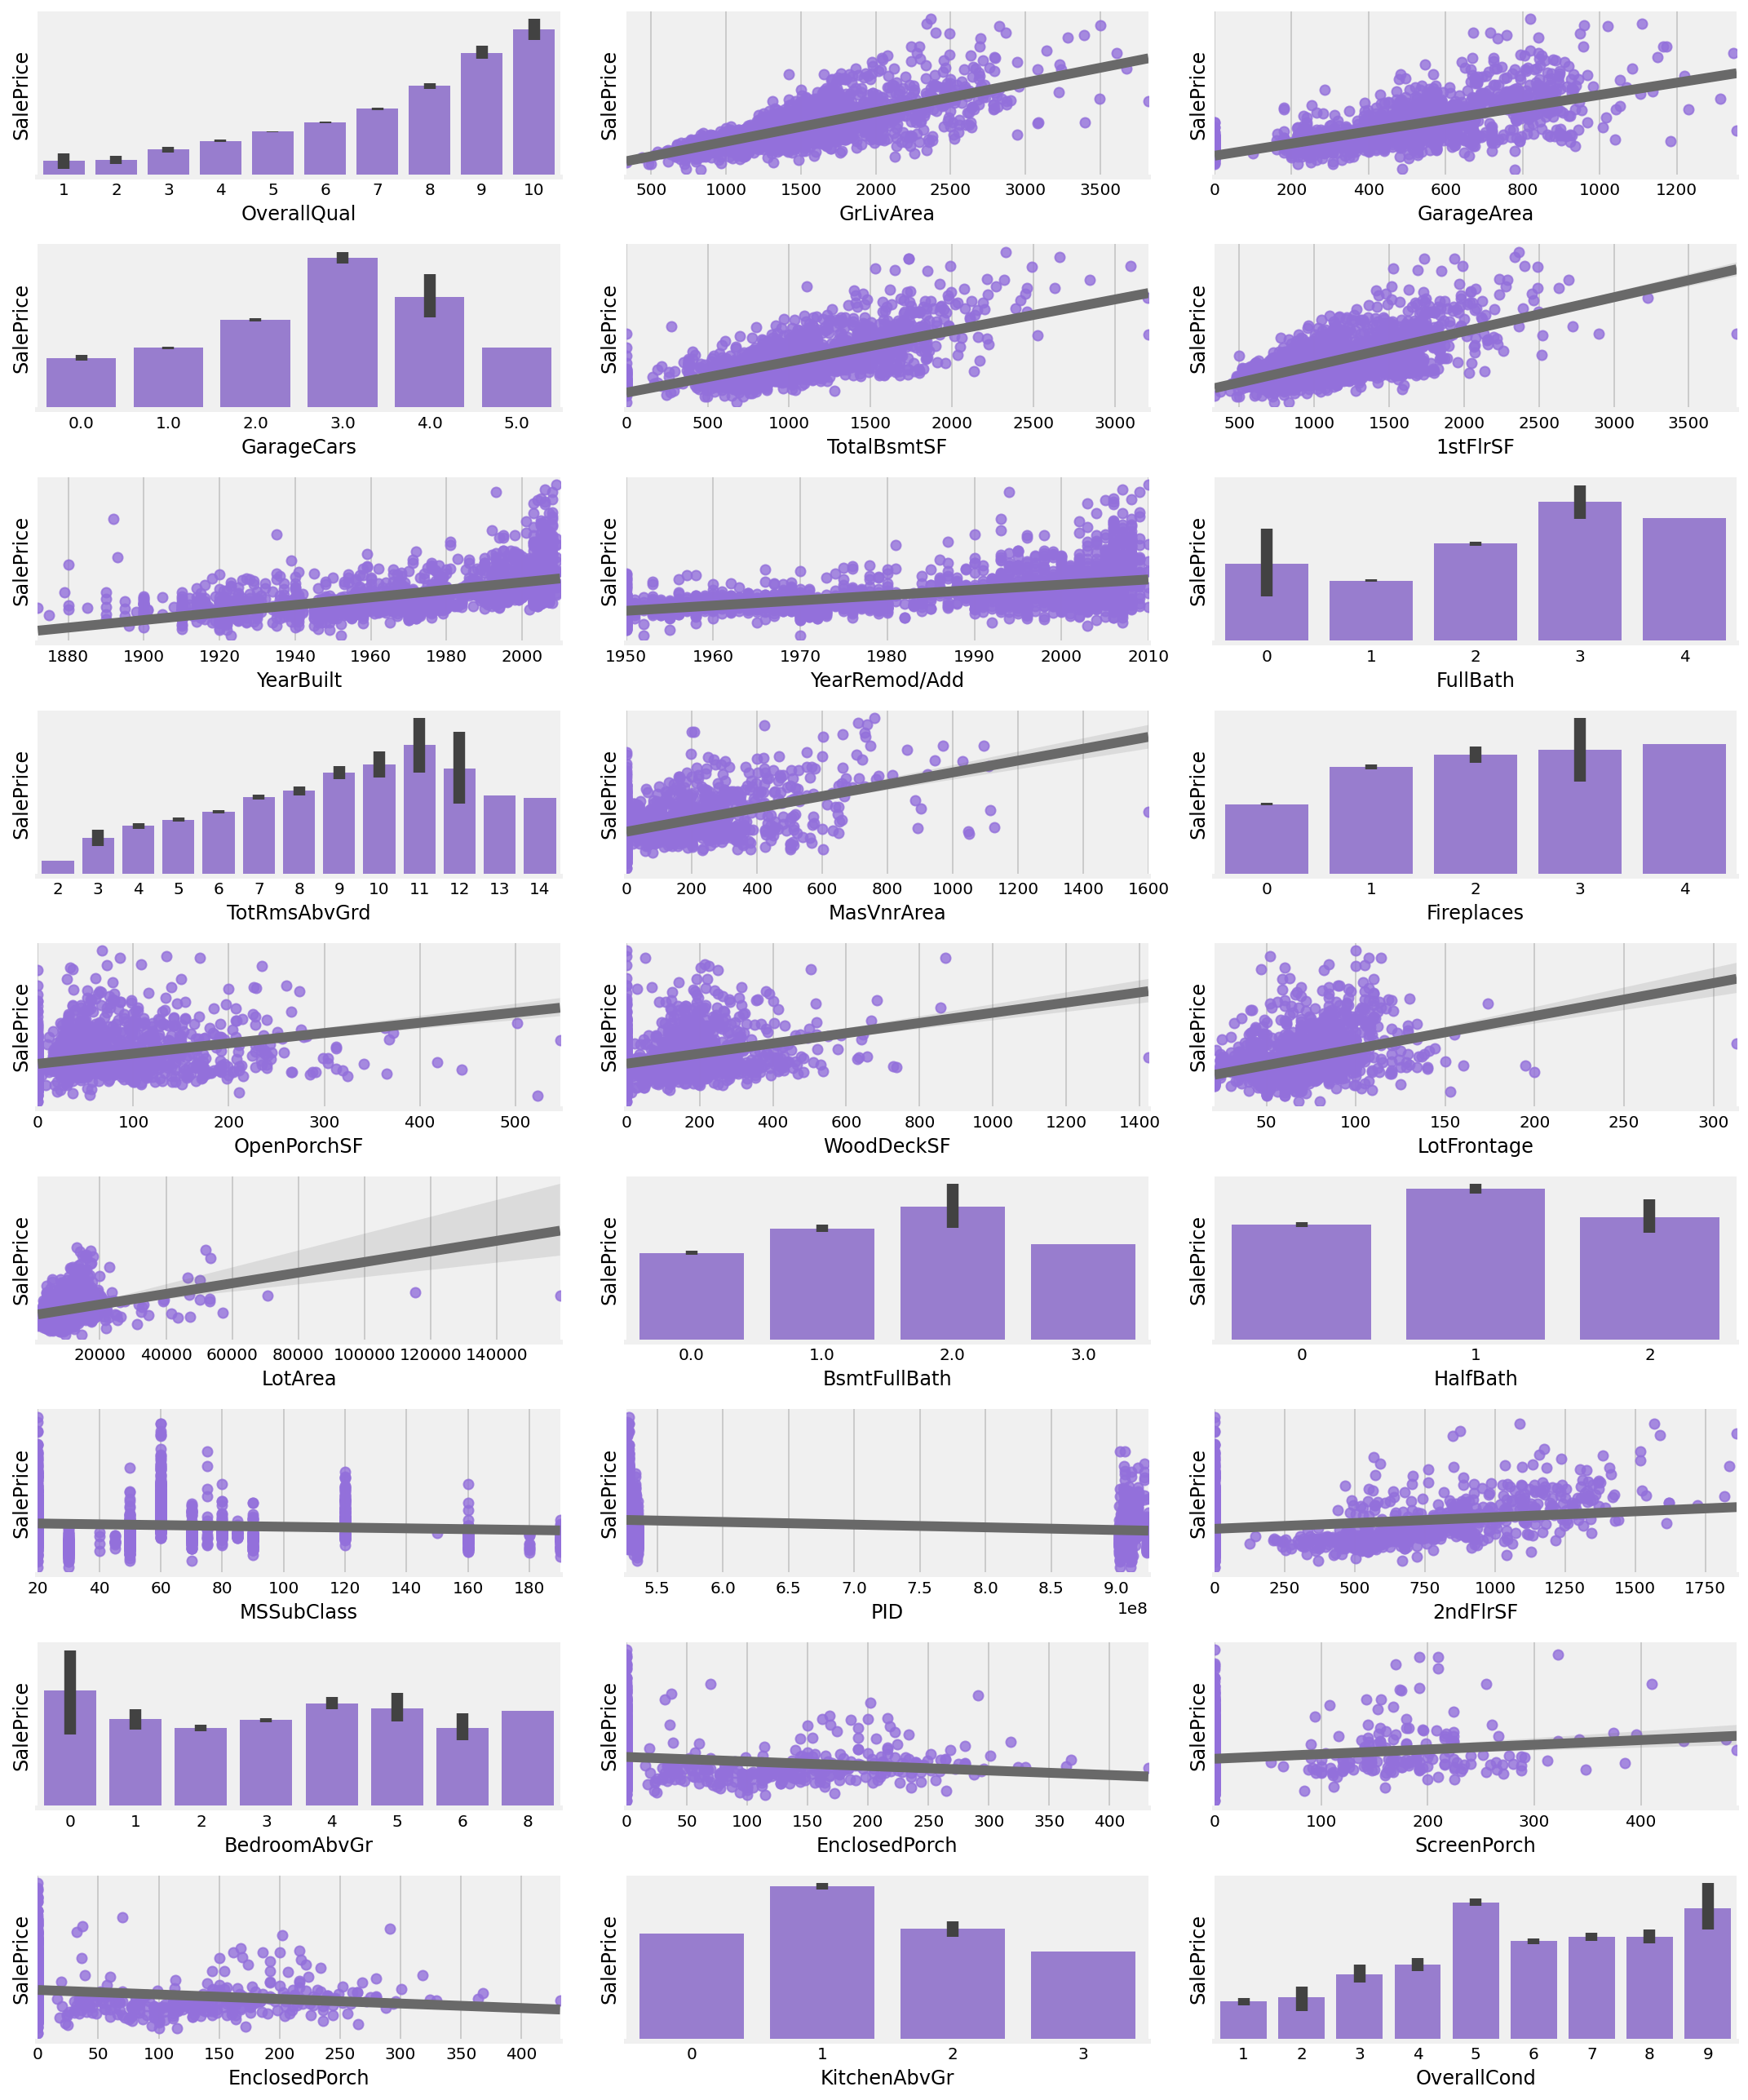

In [58]:
#lets plot some charts to see the correlation in the heatmap in more details
#We can see observe some trends in the charts such as the optimal number of baths, 
# bedrooms, Kitchens to have for a generally higher selling price
#Better the overall quality, higher the selling price
fig, axes = plt.subplots(9,3, figsize=(15,18))
sns.despine(left=True)

sns.barplot(df['OverallQual'],df['SalePrice'], ax=axes[0, 0], color="mediumpurple")
sns.regplot(df['GrLivArea'],df['SalePrice'], ax=axes[0, 1], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['GarageArea'],df['SalePrice'], ax=axes[0, 2], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.barplot(df['GarageCars'],df['SalePrice'], ax=axes[1, 0], color="mediumpurple")
sns.regplot(df['TotalBsmtSF'],df['SalePrice'], ax=axes[1, 1], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['1stFlrSF'],df['SalePrice'], ax=axes[1, 2], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['YearBuilt'],df['SalePrice'], ax=axes[2, 0], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['YearRemod/Add'],df['SalePrice'], ax=axes[2, 1], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.barplot(df['FullBath'],df['SalePrice'], ax=axes[2, 2], color="mediumpurple")
sns.barplot(df['TotRmsAbvGrd'],df['SalePrice'], ax=axes[3, 0], color="mediumpurple")
sns.regplot(df['MasVnrArea'],df['SalePrice'], ax=axes[3, 1], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.barplot(df['Fireplaces'],df['SalePrice'], ax=axes[3, 2], color="mediumpurple")
sns.regplot(df['OpenPorchSF'],df['SalePrice'], ax=axes[4, 0], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['WoodDeckSF'],df['SalePrice'], ax=axes[4, 1], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['LotFrontage'],df['SalePrice'], ax=axes[4, 2], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['LotArea'],df['SalePrice'], ax=axes[5, 0], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.barplot(df['BsmtFullBath'],df['SalePrice'], ax=axes[5, 1], color="mediumpurple")
sns.barplot(df['HalfBath'],df['SalePrice'], ax=axes[5, 2], color="mediumpurple")
sns.regplot(df['MSSubClass'],df['SalePrice'], ax=axes[6, 0], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['PID'],df['SalePrice'], ax=axes[6, 1], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['2ndFlrSF'],df['SalePrice'], ax=axes[6, 2], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.barplot(df['BedroomAbvGr'],df['SalePrice'], ax=axes[7, 0], color="mediumpurple")
sns.regplot(df['EnclosedPorch'],df['SalePrice'], ax=axes[7, 1], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['ScreenPorch'],df['SalePrice'], ax=axes[7, 2], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.regplot(df['EnclosedPorch'],df['SalePrice'], ax=axes[8, 0], color="mediumpurple", line_kws={'color':'dimgrey'})
sns.barplot(df['KitchenAbvGr'],df['SalePrice'], ax=axes[8, 1], color="mediumpurple")
sns.barplot(df['OverallCond'],df['SalePrice'], ax=axes[8, 2], color="mediumpurple")


plt.setp(axes, yticks=[])
plt.tight_layout();

Other meaningful relationships to observe:

#### Relationship between Neighborhood and Average Sale Price

In [59]:
df.groupby('Neighborhood')['SalePrice'].mean().sort_values()

Neighborhood
MeadowV    100231.250000
IDOTRR     101103.188406
BrDale     103371.052632
OldTown    125276.300613
BrkSide    127022.697368
Edwards    129905.787234
SWISU      134758.875000
Landmrk    137000.000000
Sawyer     137181.909910
NPkVill    140476.470588
Blueste    144566.666667
NAmes      145905.816129
Mitchel    167656.707317
SawyerW    187760.160920
Greens     188666.666667
Gilbert    189228.387931
NWAmes     194619.022989
Blmngtn    200417.681818
CollgCr    202497.216667
Crawfor    205901.211268
ClearCr    217490.074074
Somerst    227183.900000
Timber     241051.354167
Veenker    253570.588235
GrnHill    280000.000000
NoRidge    316294.125000
NridgHt    322831.352459
StoneBr    329675.736842
Name: SalePrice, dtype: float64

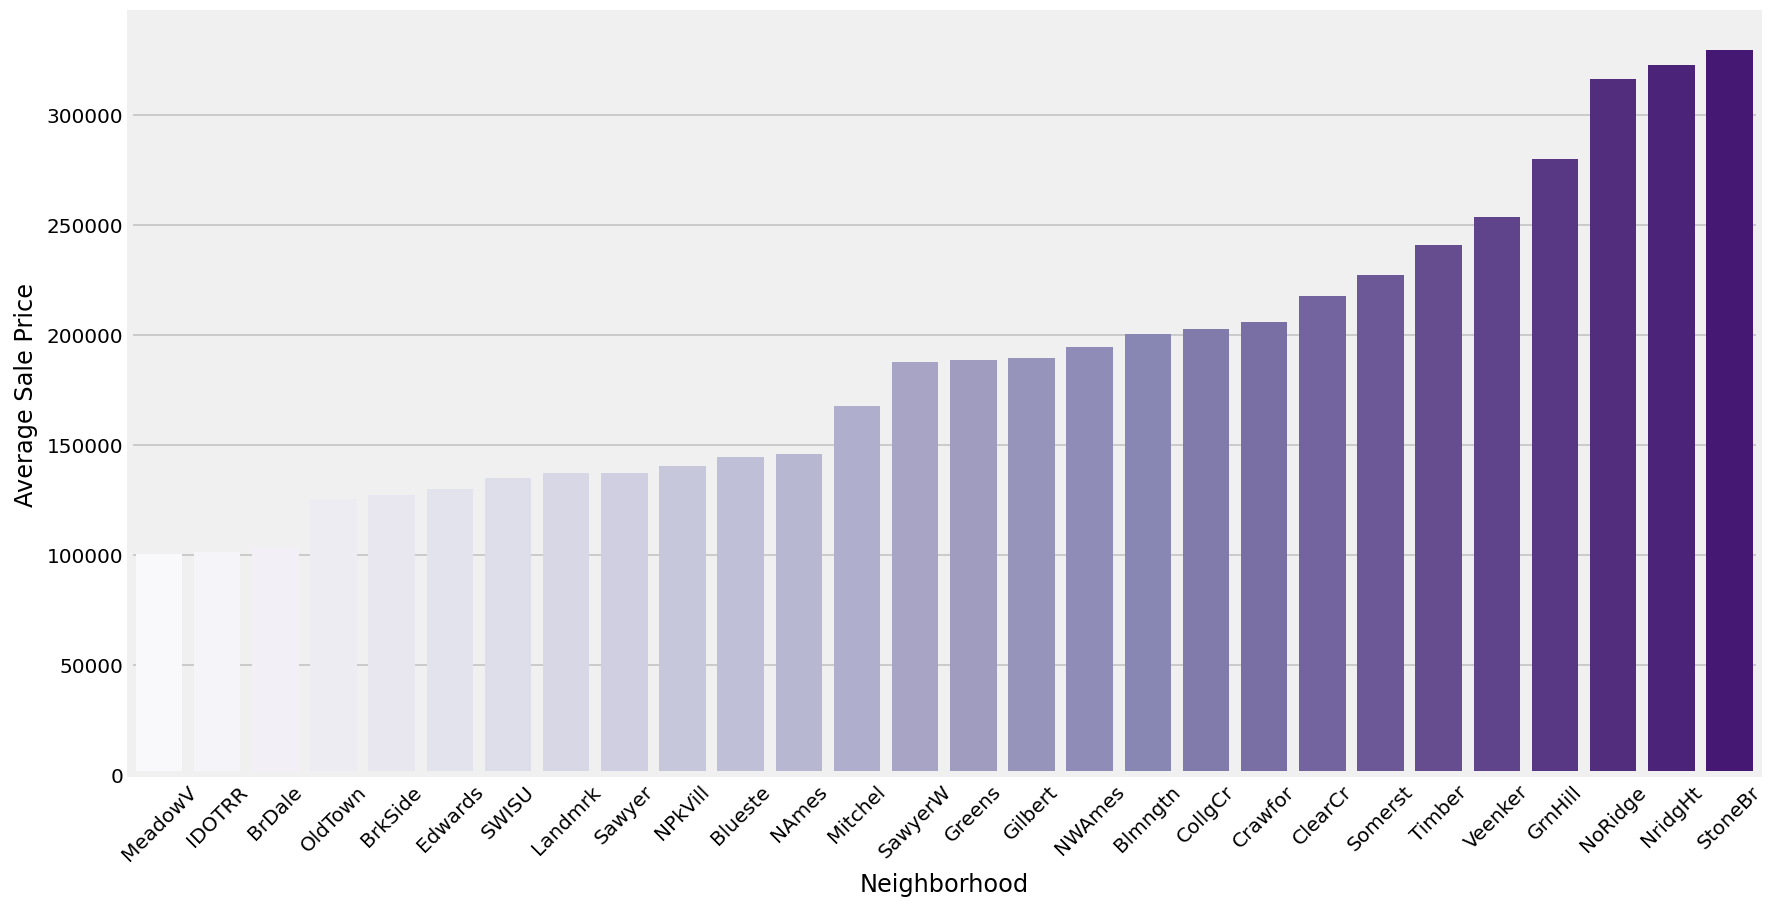

In [60]:
nbh_meanpx = df.groupby('Neighborhood')['SalePrice'].mean().sort_values().index
meanpx_nbh = df.groupby('Neighborhood')['SalePrice'].mean().sort_values().values

#Relationship between Neighborhood and Average Sale Price
plt.figure(figsize=(13,7))
sns.barplot(x=nbh_meanpx, y=meanpx_nbh, palette='Purples')
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Average Sale Price');

#Generally, Stone Brook, Northridge Heights, and Northridge have a higher mean selling price



#### Relationship between Condition and Average Sale Price

In [61]:
df.groupby('Condition1')['SalePrice'].mean().sort_values()

Condition1
Artery    128765.000000
RRNe      129616.666667
RRAe      139685.714286
Feedr     143068.268519
RRAn      172604.777778
Norm      185007.965459
RRNn      198208.333333
PosA      254733.333333
PosN      254794.296296
Name: SalePrice, dtype: float64

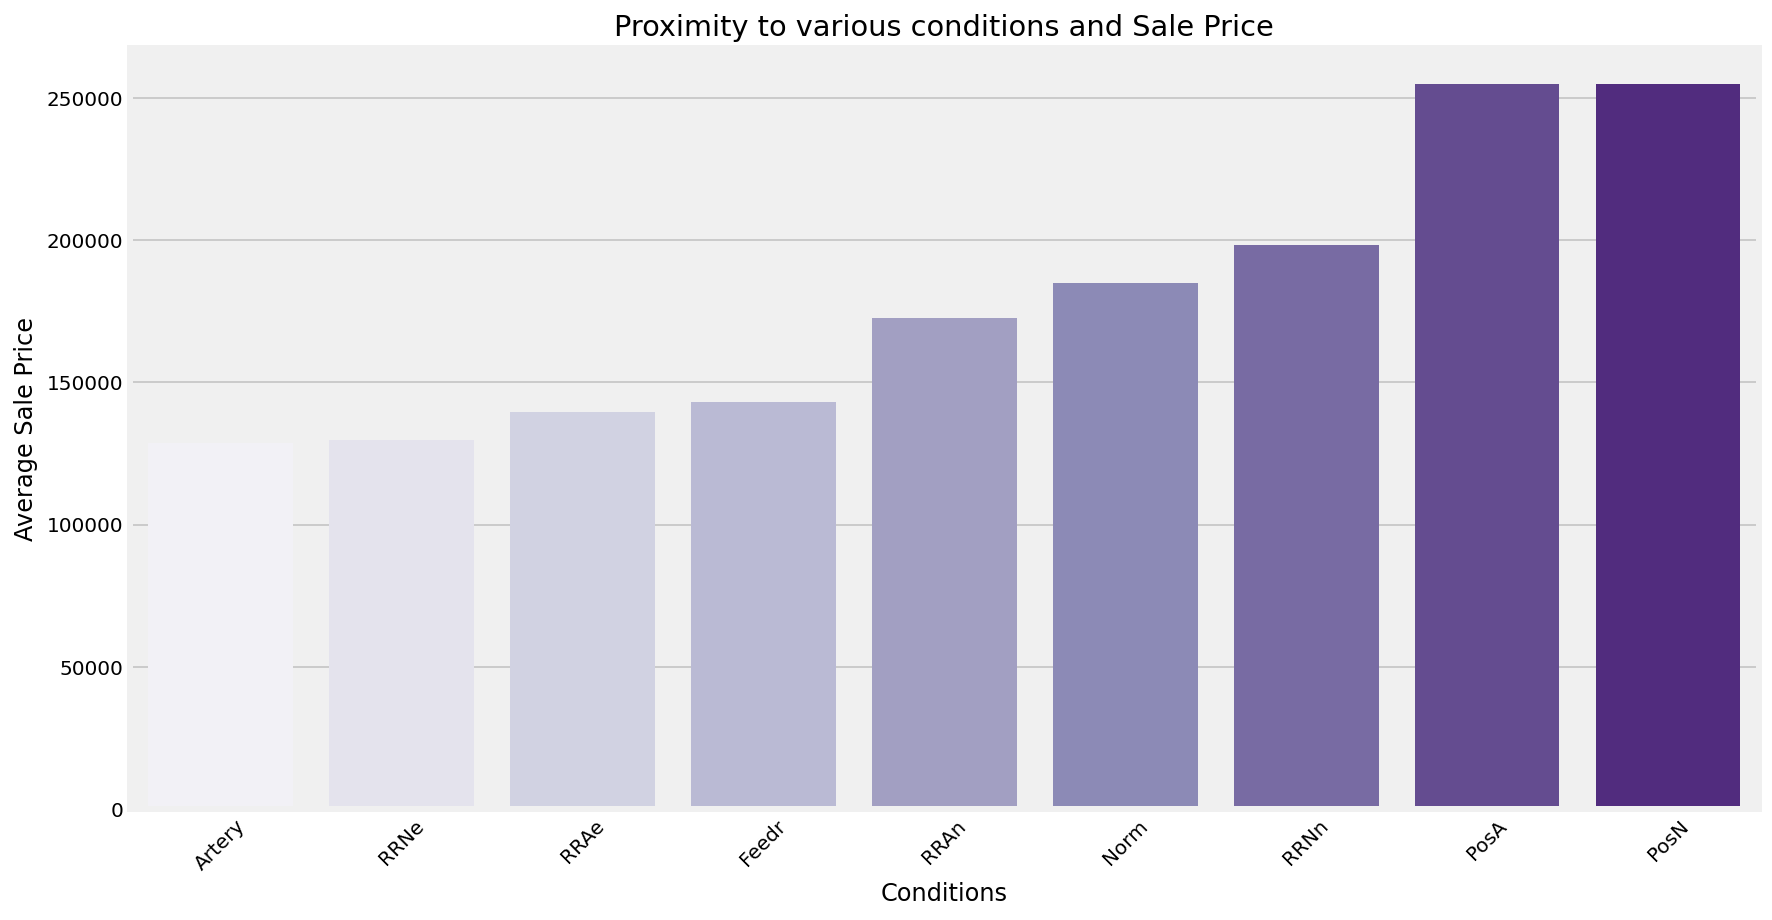

In [62]:
cond1_meanpx = df.groupby('Condition1')['SalePrice'].mean().sort_values().index
meanpx_cond1 = df.groupby('Condition1')['SalePrice'].mean().sort_values().values


plt.figure(figsize=(13,7))
sns.barplot(x=cond1_meanpx, y=meanpx_cond1, palette='Purples')
plt.xticks(rotation=45)
plt.title('Proximity to various conditions and Sale Price')
plt.xlabel('Conditions')
plt.ylabel('Average Sale Price');

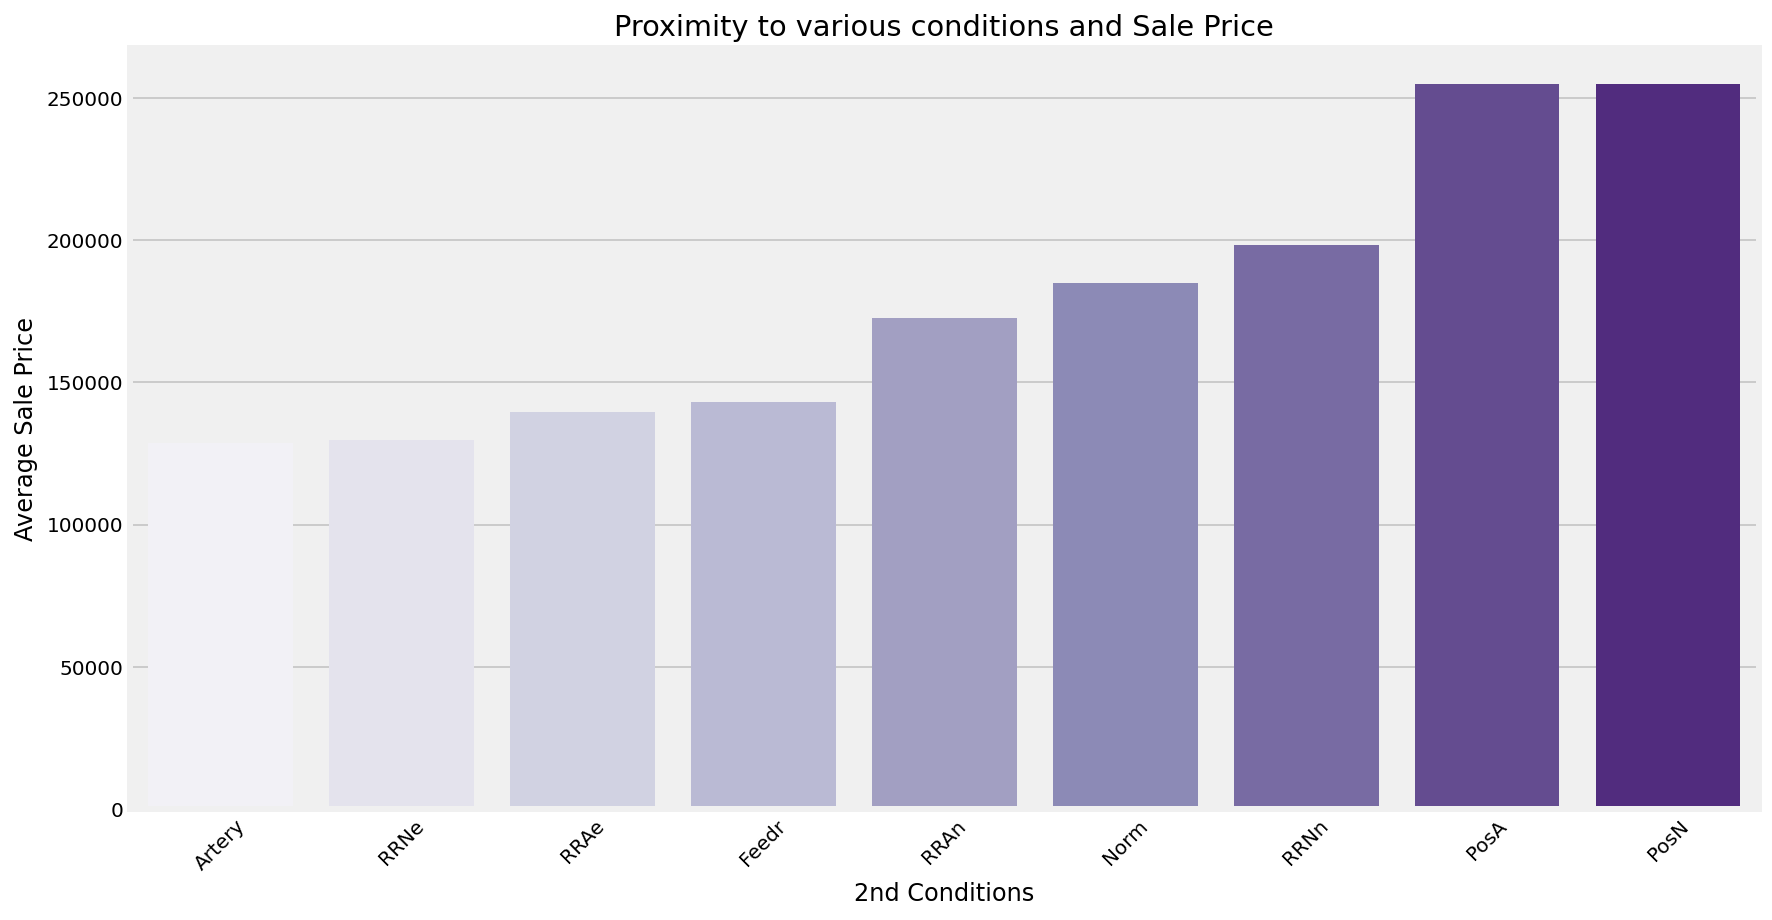

In [63]:
cond2_meanpx = df.groupby('Condition2')['SalePrice'].mean().sort_values().index
meanpx_cond2 = df.groupby('Condition2')['SalePrice'].mean().sort_values().values

plt.figure(figsize=(13,7))

plt.title('Proximity to various conditions and Sale Price')
sns.barplot(x=cond1_meanpx, y=meanpx_cond1, palette='Purples')

plt.xticks(rotation=45)
plt.xlabel('2nd Conditions')
plt.ylabel('Average Sale Price');


<u>Conditions and Sale Price</u>
<br>
In both charts above, it is consistent that properties near or adjacent positive off-site features (such as park, or other amenities) fetch a higher average Sale Price.

#### Relationship between Exterior covering on house and Sale Price

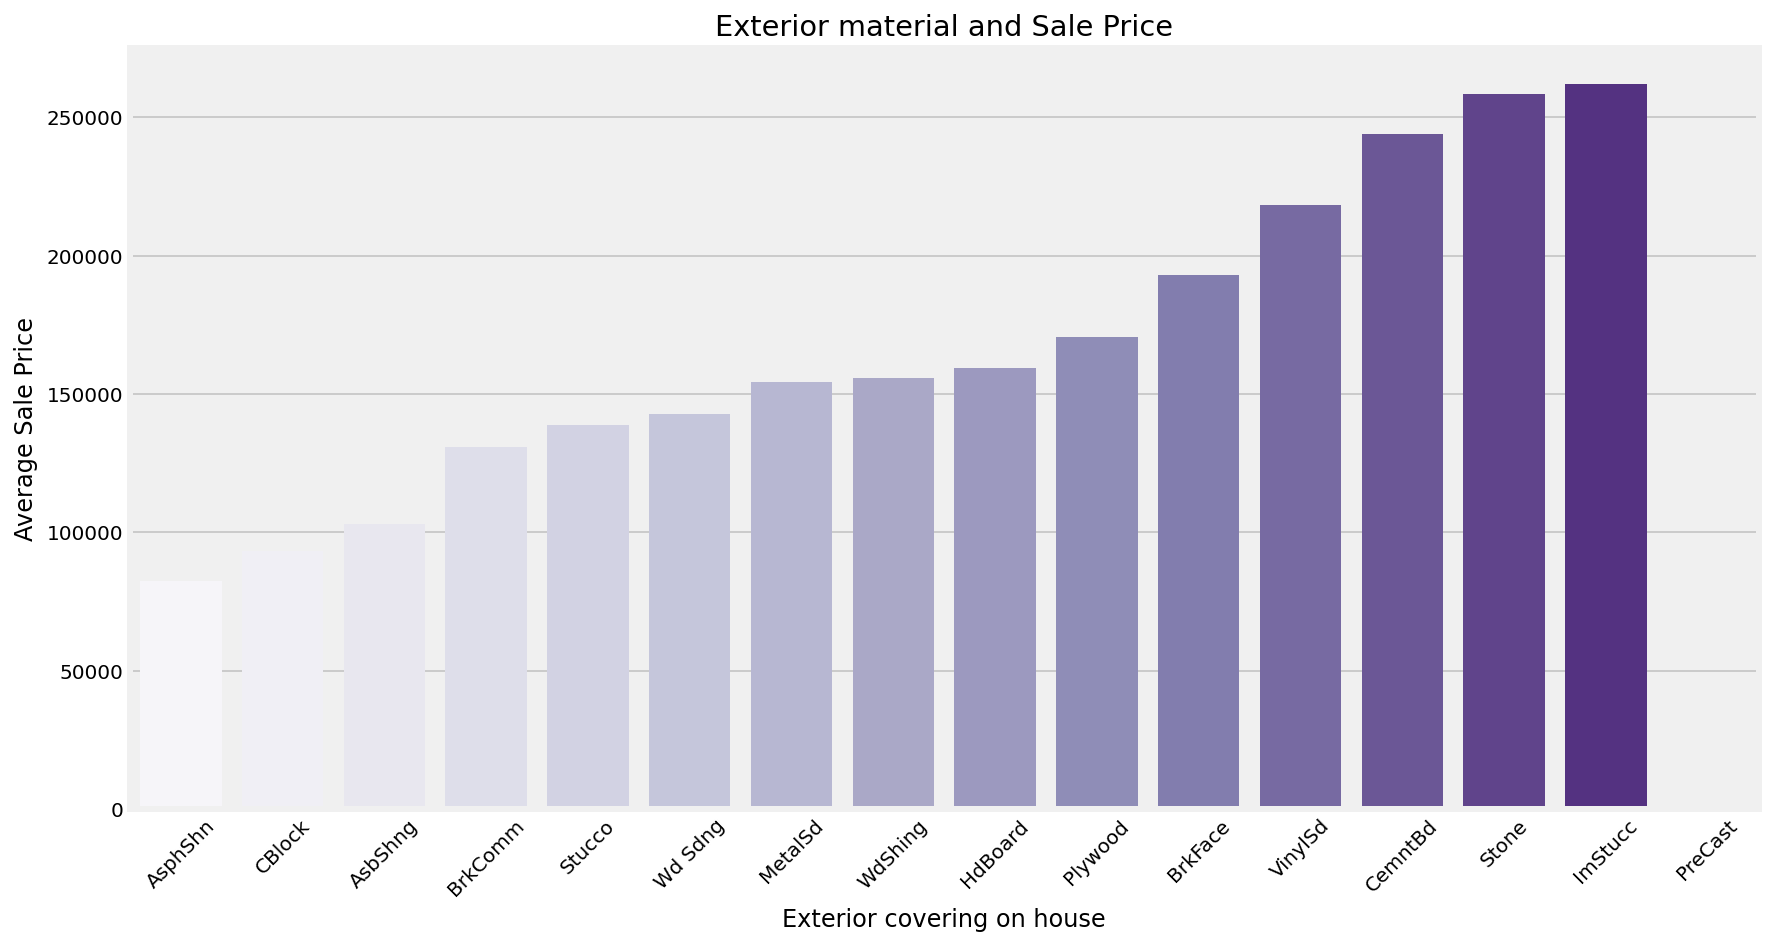

In [64]:
ext1_meanpx = df.groupby('Exterior1st')['SalePrice'].mean().sort_values().index
meanpx_ext1 = df.groupby('Exterior1st')['SalePrice'].mean().sort_values().values

plt.figure(figsize=(13,7))
plt.title('Exterior material and Sale Price')

sns.barplot(x=ext1_meanpx, y=meanpx_ext1, palette='Purples')
plt.xticks(rotation=45)
plt.xlabel('Exterior covering on house')
plt.ylabel('Average Sale Price');


#### Relationship between 2nd Exterior covering on house and Sale Price

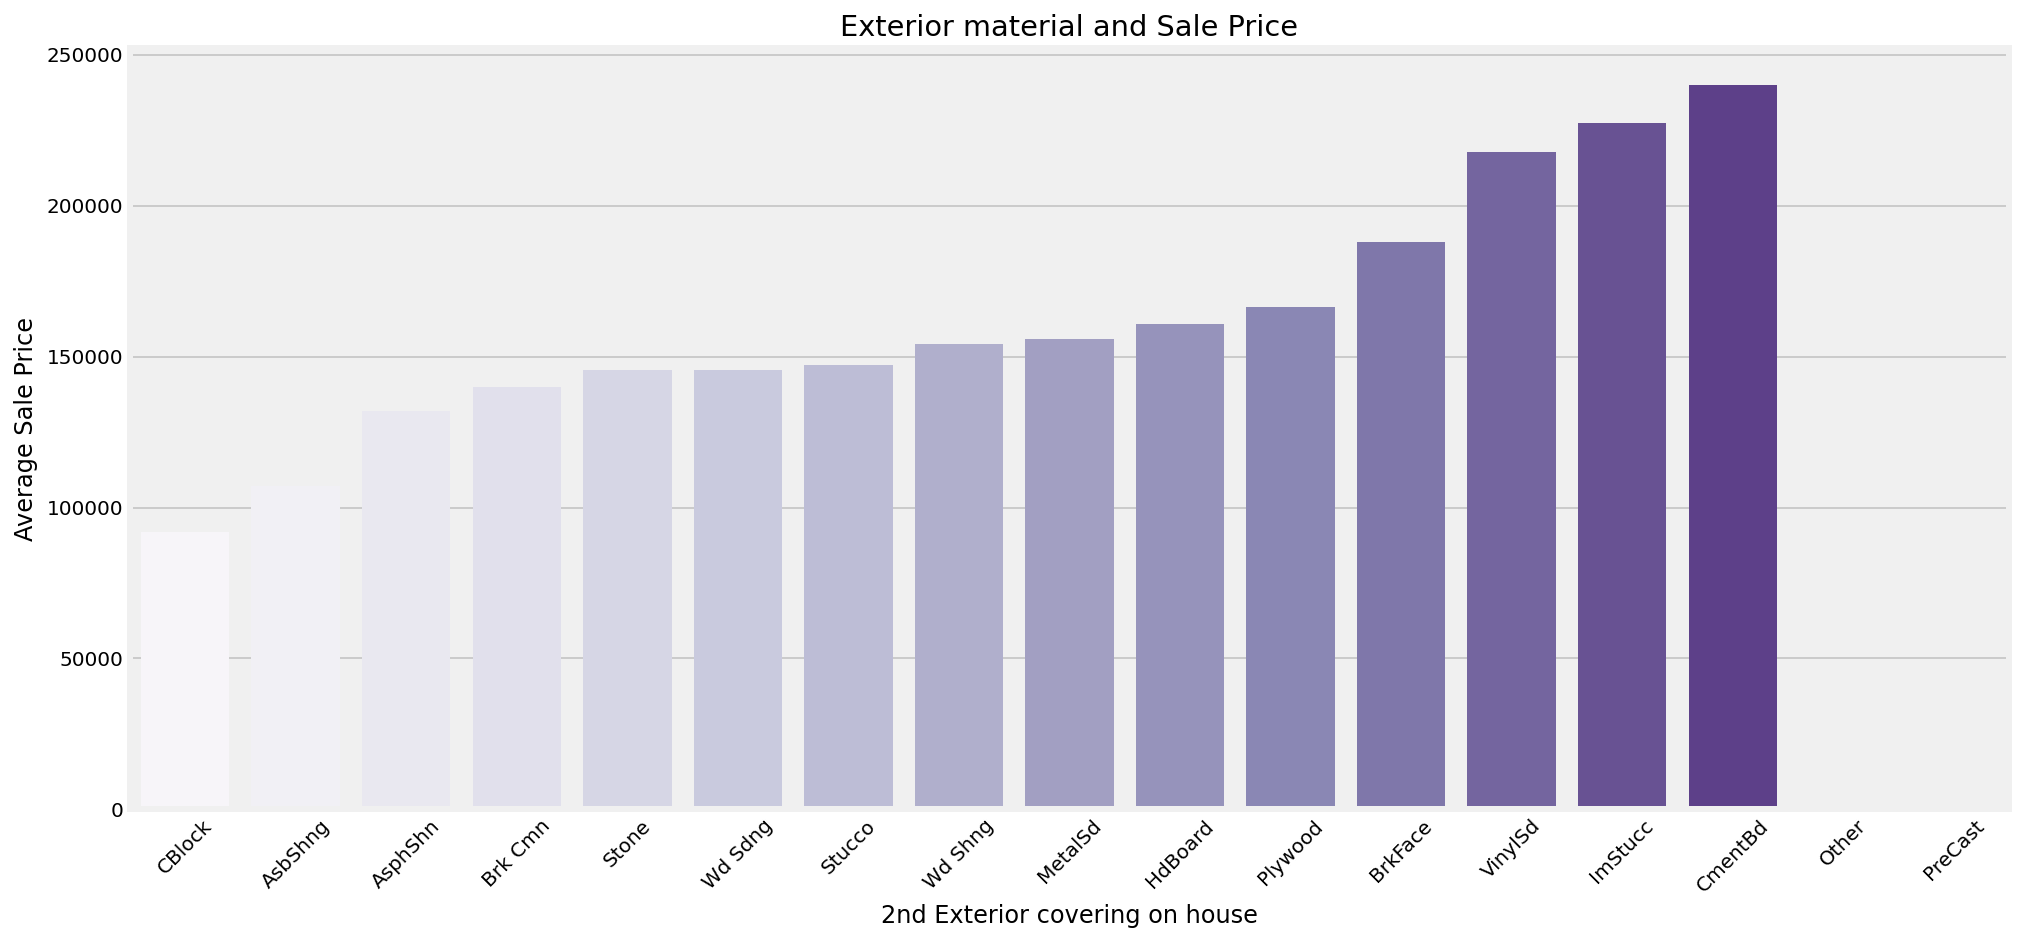

In [65]:
#Relationship between 2nd Exterior covering on house and Sale Price

ext2_meanpx = df.groupby('Exterior2nd')['SalePrice'].mean().sort_values().index
meanpx_ext2 = df.groupby('Exterior2nd')['SalePrice'].mean().sort_values().values

plt.figure(figsize=(15,7))
plt.title('Exterior material and Sale Price')
sns.barplot(x=ext2_meanpx, y=meanpx_ext2, palette='Purples')

plt.xticks(rotation=45)
plt.xlabel('2nd Exterior covering on house')
plt.ylabel('Average Sale Price');


<u>Exterior Material and Sale Price</u>
<br>
In both charts above, it is consistent that materials Imitation Stucco and Cement Board fetch a higher average Sale Price.

#### Relationship between Roof Material and Sale Price

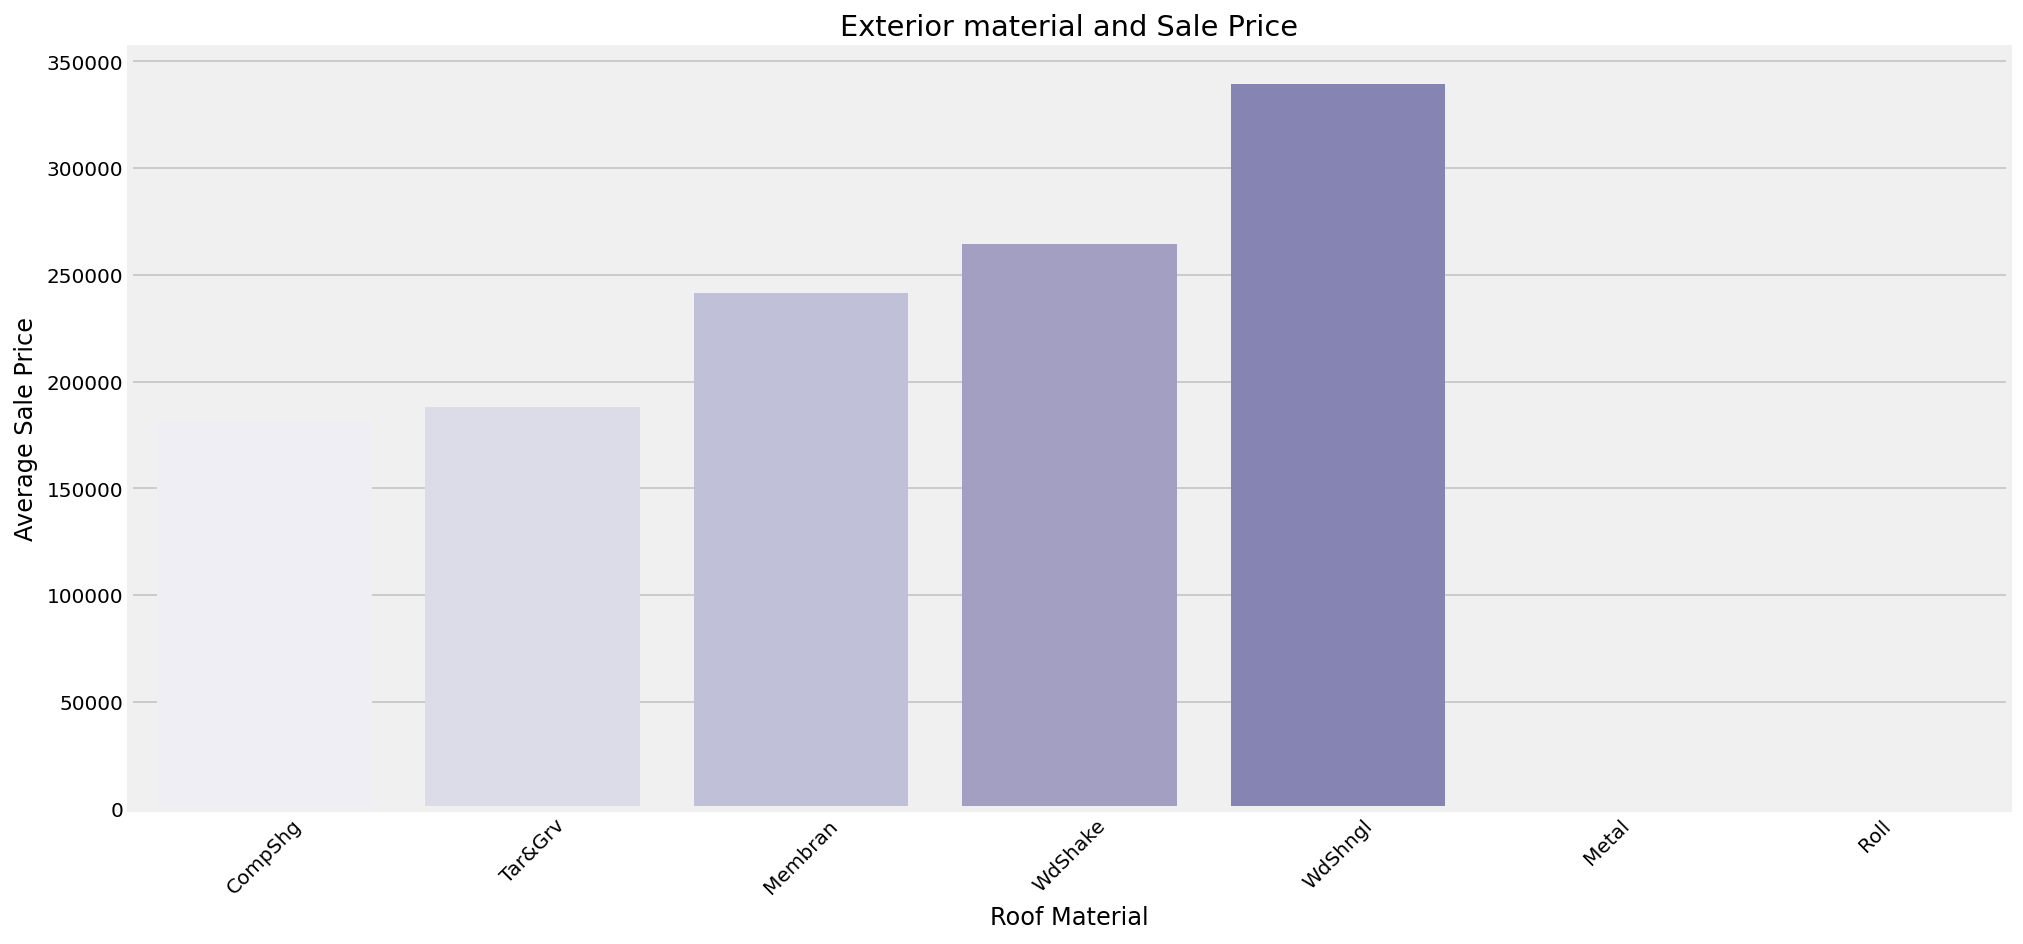

In [66]:
#Relationship between Roof Material and Sale Price

roofmat_meanpx = df.groupby('RoofMatl')['SalePrice'].mean().sort_values().index
meanpx_roofmat = df.groupby('RoofMatl')['SalePrice'].mean().sort_values().values

plt.figure(figsize=(15,7))
plt.title('Exterior material and Sale Price')
sns.barplot(x=roofmat_meanpx, y=meanpx_roofmat, palette='Purples')

plt.xticks(rotation=45)
plt.xlabel('Roof Material')
plt.ylabel('Average Sale Price');

<u>Roof Material and Sale Price</u>
<br>
Wood is good for a roof material: Roofs made of Wood Shakes Wood Shingles fetch a higher average selling price

<a id='02'></a>
### Pre-processing and Feature Engineering

<a id='label_encode'></a>
#### Ordinal Features

In [67]:
#nested dictionary to replace keys with values to reflect
   #  weight in ordinal features for modelling

ordinal_dict = {'LotShape': {'Reg' : 4 ,  #Regular
                            'IR1' : 3 ,   #Slightly irregular
                            'IR2' : 2 ,   #Moderately irregular
                            'IR3' : 1 ,   #Irregular
                            'NA' : 0} ,      #None
                
               'Utilities': {'AllPub': 4, #All public Utilities (E,G,W,& S)
                            'NoSewr' : 3 ,#Electricity, Gas, and Water (Septic Tank)
                            'NoSeWa' : 2 ,#Electricity and Gas Only
                            'ELO' : 1 ,   #Electricity only
                            'NA' : 0} ,      #None  
                
               'LandSlope' : {'Gtl' : 3 , #Gentle slope
                            'Mod' : 2 ,   #Moderate Slope
                            'Sev' : 1,    #Severe Slope
                            'NA' : 0} ,      #None
               
               'ExterQual': {'Ex' : 5 ,   #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' : 0} ,       #None

               'ExterCond' :{'Ex' : 5 ,   #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' :0} ,       #None

               'BsmtQual' : {'Ex' : 5 ,   #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' : 0} ,      #None

               'BsmtCond' :  {'Ex' : 5 ,  #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' :0} ,       #None

               'BsmtExposure': {'Gd' : 4, #Good Exposure 
                            'Av' : 3 ,    #Average Exposure
                            'Mn' : 2 ,    #Mimimum Exposure
                            'No' : 1 ,    #No Exposure
                            'NA' : 0 ,    #No Basement
                            'NA' :0} ,       #None
                
               'BsmtFinType1': {'GLQ' :6, #Good Living Quarters
                            'ALQ' :5 ,    #Average Living Quarters
                            'BLQ' :4 ,    #Below Average Living Quarters	
                            'Rec' :3 ,    #Average Rec Room
                            'LwQ' :2 ,    #Low Quality
                            'Unf' :1 ,    #Unfinshed
                            'NA' :0 ,     #No Basement
                            0 :0} ,       #No Basement

               'BsmtFinType2': {'GLQ' :6, #Good Living Quarters
                            'ALQ' :5 ,    #Average Living Quarters
                            'BLQ' :4 ,    #Below Average Living Quarters	
                            'Rec' :3 ,    #Average Rec Room
                            'LwQ' :2 ,    #Low Quality
                            'Unf' :1 ,    #Unfinshed
                            'NA' :0 ,     #No Basement
                            0 :0} ,       #No Basement

              'HeatingQC': {'Ex' : 5 ,    #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' :0} ,       #None

               'Electrical':{'SBrkr' : 5 ,#Standard Circuit Breakers & Romex
                            'FuseA' : 4 , #Fuse Box over 60 AMP and all Romex wiring (Average)	
                            'FuseF' : 3 , #60 AMP Fuse Box and mostly Romex wiring (Fair)
                            'FuseP' : 2 , #60 AMP Fuse Box and mostly knob & tube wiring (poor)
                            'Mix' : 1 ,   #Mixed
                            'NA' : 0} ,      #None

               'KitchenQual':{'Ex' : 5 ,  #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' :0 ,     #None
                            0 :0} ,       #None

               'Functional':{'Typ' : 8 ,  #Typical Functionality
                            'Min1' : 7 ,  #Minor Deductions 1
                            'Min2' : 6 ,  #Minor Deductions 2
                            'Mod' : 5 ,   #Moderate Deductions
                            'Maj1' : 4 ,  #Major Deductions 1
                            'Maj2' : 3 ,  #Major Deductions 2
                            'Sev' : 2 ,   #Severely Damaged
                            'Sal' : 1 ,   #Salvage only
                            'NA' :0} ,       #None

              'FireplaceQu':{'Ex' : 5 ,   #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' : 0 ,    #None
                            0 : 0} ,      #None

               'GarageFinish':{'Fin': 3 , #Finished
                            'RFn': 2 ,    #Rough Finished
                            'Unf': 1 ,    #Unfinished
                            'NA' : 0 ,    #No Garage
                              0 : 0},   


               'GarageQual':{'Ex' : 5 ,   #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' : 0 ,    #None
                            0 : 0} ,      #None

               'GarageCond':{'Ex' : 5 ,   #Excellent 
                            'Gd' : 4 ,    #Good
                            'TA' : 3 ,    #Average/Typical
                            'Fa' : 2 ,    #Fair
                            'Po' : 1 ,    #Poor
                            'NA' : 0 ,    #None
                            0 : 0} ,      #None
                
              'PavedDrive': {'Y' : 3 ,    #Paved 
                            'P' : 2 ,     #Partial Pavement
                            'N' : 1 ,     #Dirt/Gravel
                            'NA' : 0} ,      #None

               'PoolQC':   {'Ex' : 4 ,    #Excellent 
                            'Gd' : 3 ,    #Good
                            'TA' : 2 ,    #Average/Typical
                            'Fa' : 1 ,    #Fair
                            'NA' : 0 ,    #None
                            0 : 0} ,      #None
                
               'Fence':    {'GdPrv' : 4 , #Good Privacy
                            'MnPrv' : 3 , #Minimum Privacy
                            'GdWo' : 2 ,  #Good Wood
                            'MnWw' : 1 ,  #Minimum Wood/Wire
                            'NA' : 0 ,    #No Fence
                            0 : 0} ,      #None

              }

In [68]:
#function to replace str with values for ordinal features
def replacemap_value(df, replace_dict):
    
    for k,v in replace_dict.items():  
#identify dataseries'k' and map values 'v' in dict to replace
        df[k] = df[k].map(v)

In [69]:
#apply function
#We get a dataset of transformed ordinal features
#  which we can now apply in our modelling
replacemap_value(df, ordinal_dict)
df.head()

,Id,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,109,533352170,60,RL,69.22459,13517,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,3,2010,WD,130500.0
1,544,531379050,60,RL,43.00000,11492,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,4,2009,WD,220000.0
2,153,535304180,20,RL,68.00000,7922,Pave,NA,4,Lvl,...,0,0,0,0,NA,0,1,2010,WD,109000.0
3,318,916386060,60,RL,73.00000,9802,Pave,NA,4,Lvl,...,0,0,0,0,NA,0,4,2010,WD,174000.0
4,255,906425045,50,RL,82.00000,14235,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,3,2010,WD,138500.0


In [70]:
#save merged dataframe before dummy variables
df.to_csv('../datasets/df_b4dum.csv', index=False)

<a id='one-hot'></a>
#### One-hot encoding

In [71]:
df = pd.get_dummies(df, drop_first=False)

In [72]:
#Shape after get_dummies
df.shape

(2928, 224)

In [73]:
#save merged dataframe after encoding and cleaning
df.to_csv('../datasets/df.csv', index=False)

In [74]:
#separate train and test dataframes after hot-encoding

In [75]:
train_clean = df.iloc[0: 2049, :].copy()
train_clean.shape

(2049, 224)

In [76]:
test_clean = df.iloc[2049:, :].copy()
test_clean.shape

(879, 224)

In [77]:
#drop SalePrice column from test with dummies set
test_clean.drop(['SalePrice'],axis=1,inplace=True)
test_clean.shape

(879, 223)

In [78]:
test_clean.head()

,Id,PID,MSSubClass,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD
2051,2658,902301120,190,69.00000,9142,4,4,3,6,8,...,0,0,0,0,0,0,0,0,0,1
2052,2718,905108090,90,69.22459,9662,3,4,3,5,4,...,0,0,0,0,0,0,0,0,0,1
2053,2414,528218130,60,58.00000,17104,3,4,3,7,5,...,0,0,0,0,0,0,1,0,0,0
2054,1989,902207150,30,60.00000,8520,4,4,3,5,6,...,0,0,0,0,0,0,0,0,0,1
2055,625,535105100,20,69.22459,9500,3,4,3,6,5,...,0,0,0,0,0,0,0,0,0,1


#### Save files for cleaned data

In [79]:
#Save to new csv file for cleaned train data
train_clean.to_csv('../datasets/train_clean.csv', index=False)

In [80]:
#Save to new csv file for cleaned test data
test_clean.to_csv('../datasets/test_clean.csv', index=False)

<a id='feat_select'></a>
### Feature Selection

#### Assigning Features and Target variable

In [81]:
#assign variables to target and features
target = 'SalePrice'
features = [col for col in train_clean.columns if col != target]

In [82]:
X_mod_1 = train_clean[features]
y = train_clean[target]


#### Train test split and scaling

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_mod_1, y, random_state=42)

In [84]:
#Scale data
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

#### Evaluating the initial model before feature selection

In [85]:
#Instantiate
olr = LinearRegression()
olr.fit(X_train_ss, y_train)

LinearRegression()

In [86]:
print("R-squared:", olr.score(X_train_ss, y_train))
print("Intercept:", olr.intercept_)
print("Coefficients:", olr.coef_)

R-squared: 0.926250493421464
Intercept: 181486.4254990527
Coefficients: [-6.37789462e+03  1.08835815e+03 -6.37411415e+03  2.44074953e+03
  4.47363564e+03  7.87535963e+02  8.04674176e+15  6.71594724e+01
  1.01540701e+04  5.39935352e+03  8.34368750e+03  5.99250000e+02
  5.87868750e+03  5.43900000e+03 -5.12828125e+02  1.85840625e+03
 -3.34031250e+03  5.17712500e+03  3.26196875e+03 -6.18125000e+01
  9.68775000e+03  8.89375000e+02 -5.40500000e+02  1.79571788e+15
  2.01280365e+15  2.48972187e+14 -2.30544852e+15  4.87975000e+03
  1.03650000e+03  1.36037500e+03  1.83775000e+03 -4.60975000e+03
 -3.31400000e+03  4.91525000e+03  2.48100000e+03  3.91402930e+03
  2.22253125e+03 -1.97562500e+02 -1.74976562e+04  6.31937500e+02
  2.55268750e+03  2.55300000e+03  5.37890625e+03 -1.79840625e+03
  1.11678906e+03  1.50075000e+03  3.22812500e+02  2.14125000e+02
  2.24421875e+02  4.03885938e+03 -3.37500000e+02  5.61250000e+02
  5.88468750e+02  4.63000000e+02 -2.11750000e+02 -6.24387500e+03
  3.24674666e+13  

In [87]:
olr.score(X_test_ss, y_test)

-1.0688594926065828e+20

In [88]:
pred = olr.predict(X_test)

In [89]:
pred[:5]

array([-5.16262311e+17, -8.96792806e+17, -3.62163879e+17, -7.44811516e+17,
       -4.25760359e+17])

In [90]:
r2_score(y_test, pred)

-7.726377656253858e+25

#### Selection of features using lasso model

In [91]:
#Instantiate model
lasso_mod_1 = LassoCV(n_alphas=200)

In [92]:
#Fit model
lasso_mod_1.fit(X_train_ss, y_train)

LassoCV(n_alphas=200)

#### Evaluating the initial model

In [93]:
#Score train data
lasso_mod_1.score(X_train_ss, y_train)

0.9210053526364539

In [94]:
#Score test data
lasso_mod_1.score(X_test_ss, y_test)

0.9154227329357224

In [95]:
mod_1_pred = lasso_mod_1.predict(test_clean[features])

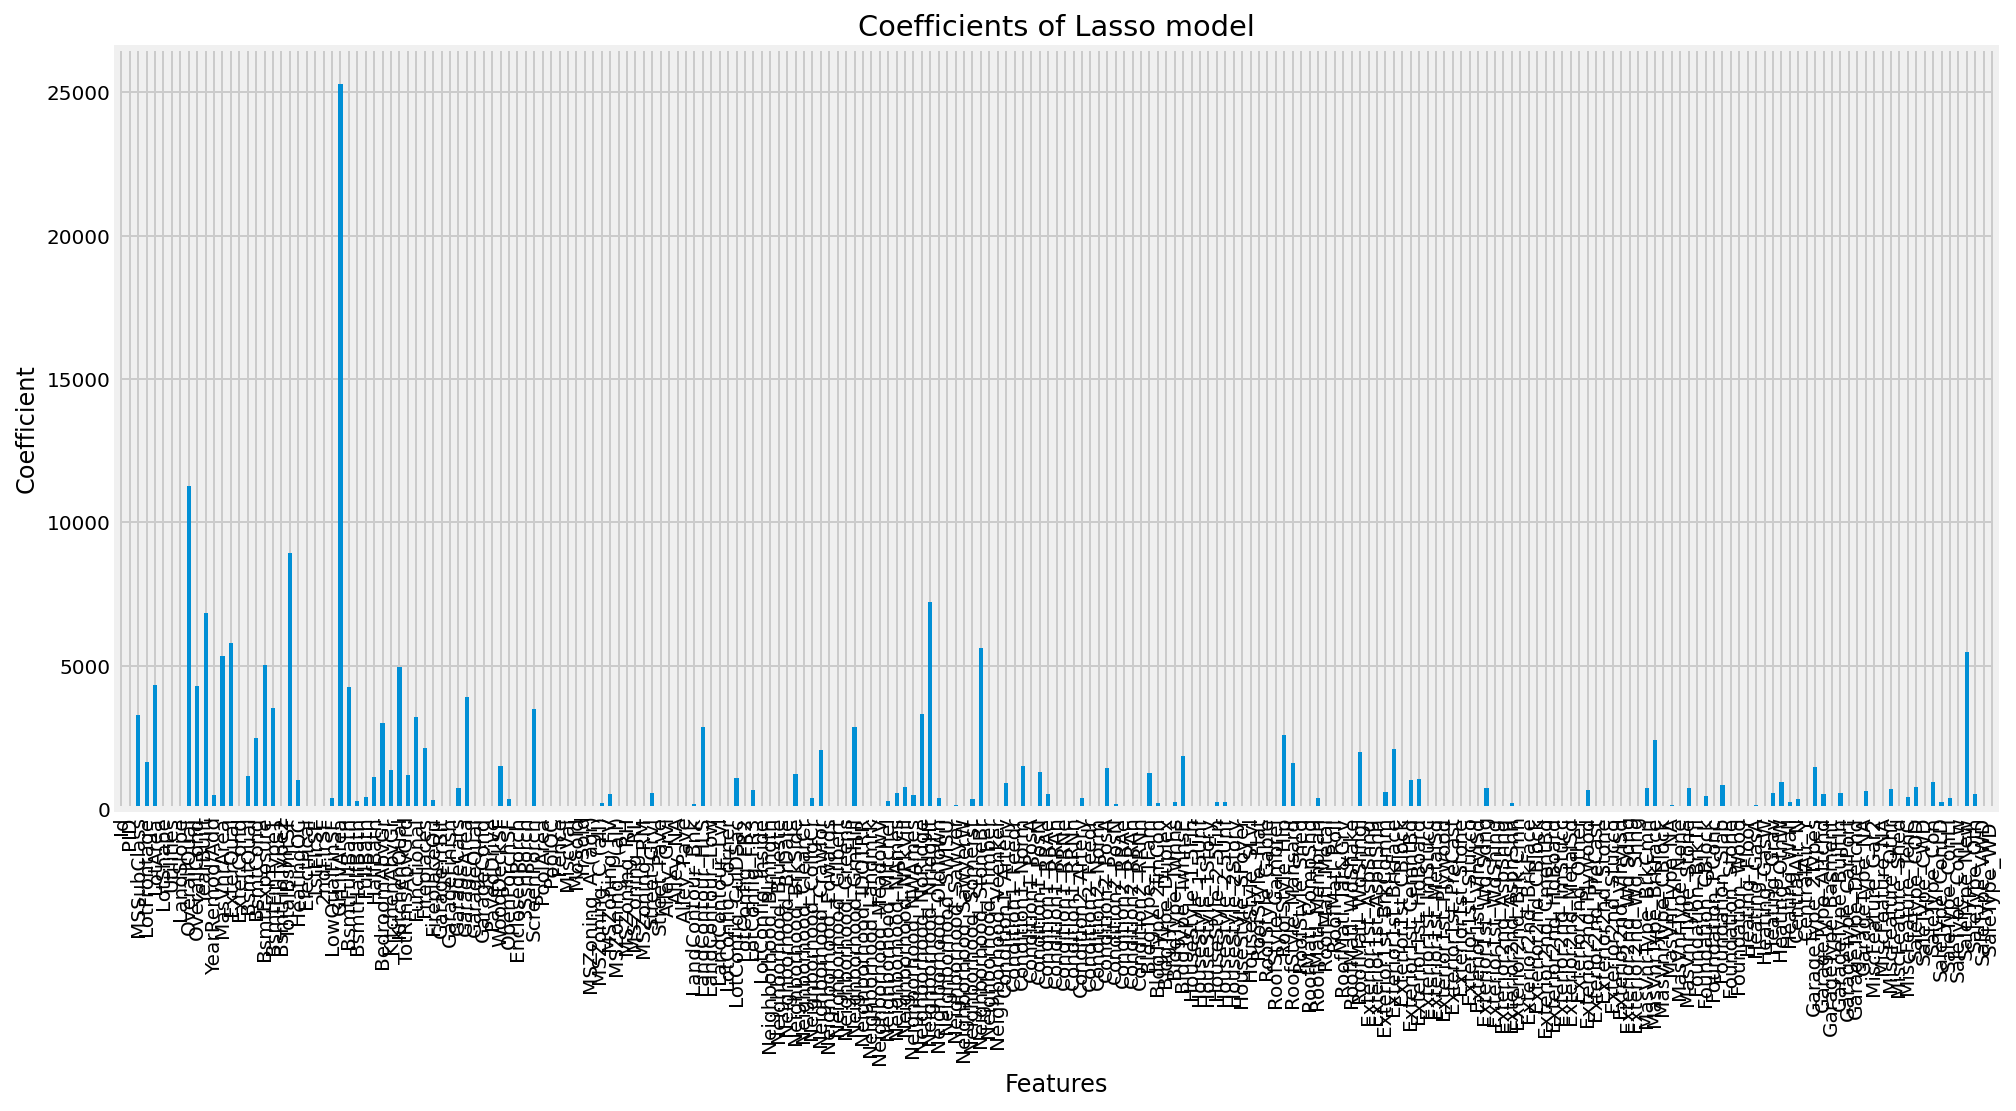

In [96]:
#For visualisation purposes
pd.Series(np.abs(lasso_mod_1.coef_), index=features).plot.bar(figsize=(15, 7))
plt.title('Coefficients of Lasso model');
plt.xlabel('Features');
plt.ylabel('Coefficient');

In [97]:
# find features with highest coefficients from Lasso

lasso_features = pd.DataFrame(X_mod_1.columns, columns=['features'])
lasso_features['coef'] = lasso_mod_1.coef_
lasso_features['abs_coef'] = np.abs(lasso_mod_1.coef_)
lasso_feat = lasso_features.sort_values(by='abs_coef', ascending=False).head(10)
lasso_feat

,features,coef,abs_coef
26,GrLivArea,25287.794889,25287.794889
8,OverallQual,11265.061333,11265.061333
20,TotalBsmtSF,8942.208789,8942.208789
96,Neighborhood_NridgHt,7220.963268,7220.963268
10,YearBuilt,6831.175302,6831.175302
13,ExterQual,5773.320484,5773.320484
102,Neighborhood_StoneBr,5631.057346,5631.057346
219,SaleType_New,5475.325265,5475.325265
12,MasVnrArea,5327.414354,5327.414354
17,BsmtExposure,5022.402152,5022.402152


In [98]:
#features determined by lasso model
features_1 = lasso_feat['features'].values
features_1

array(['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'Neighborhood_NridgHt',
       'YearBuilt', 'ExterQual', 'Neighborhood_StoneBr', 'SaleType_New',
       'MasVnrArea', 'BsmtExposure'], dtype=object)

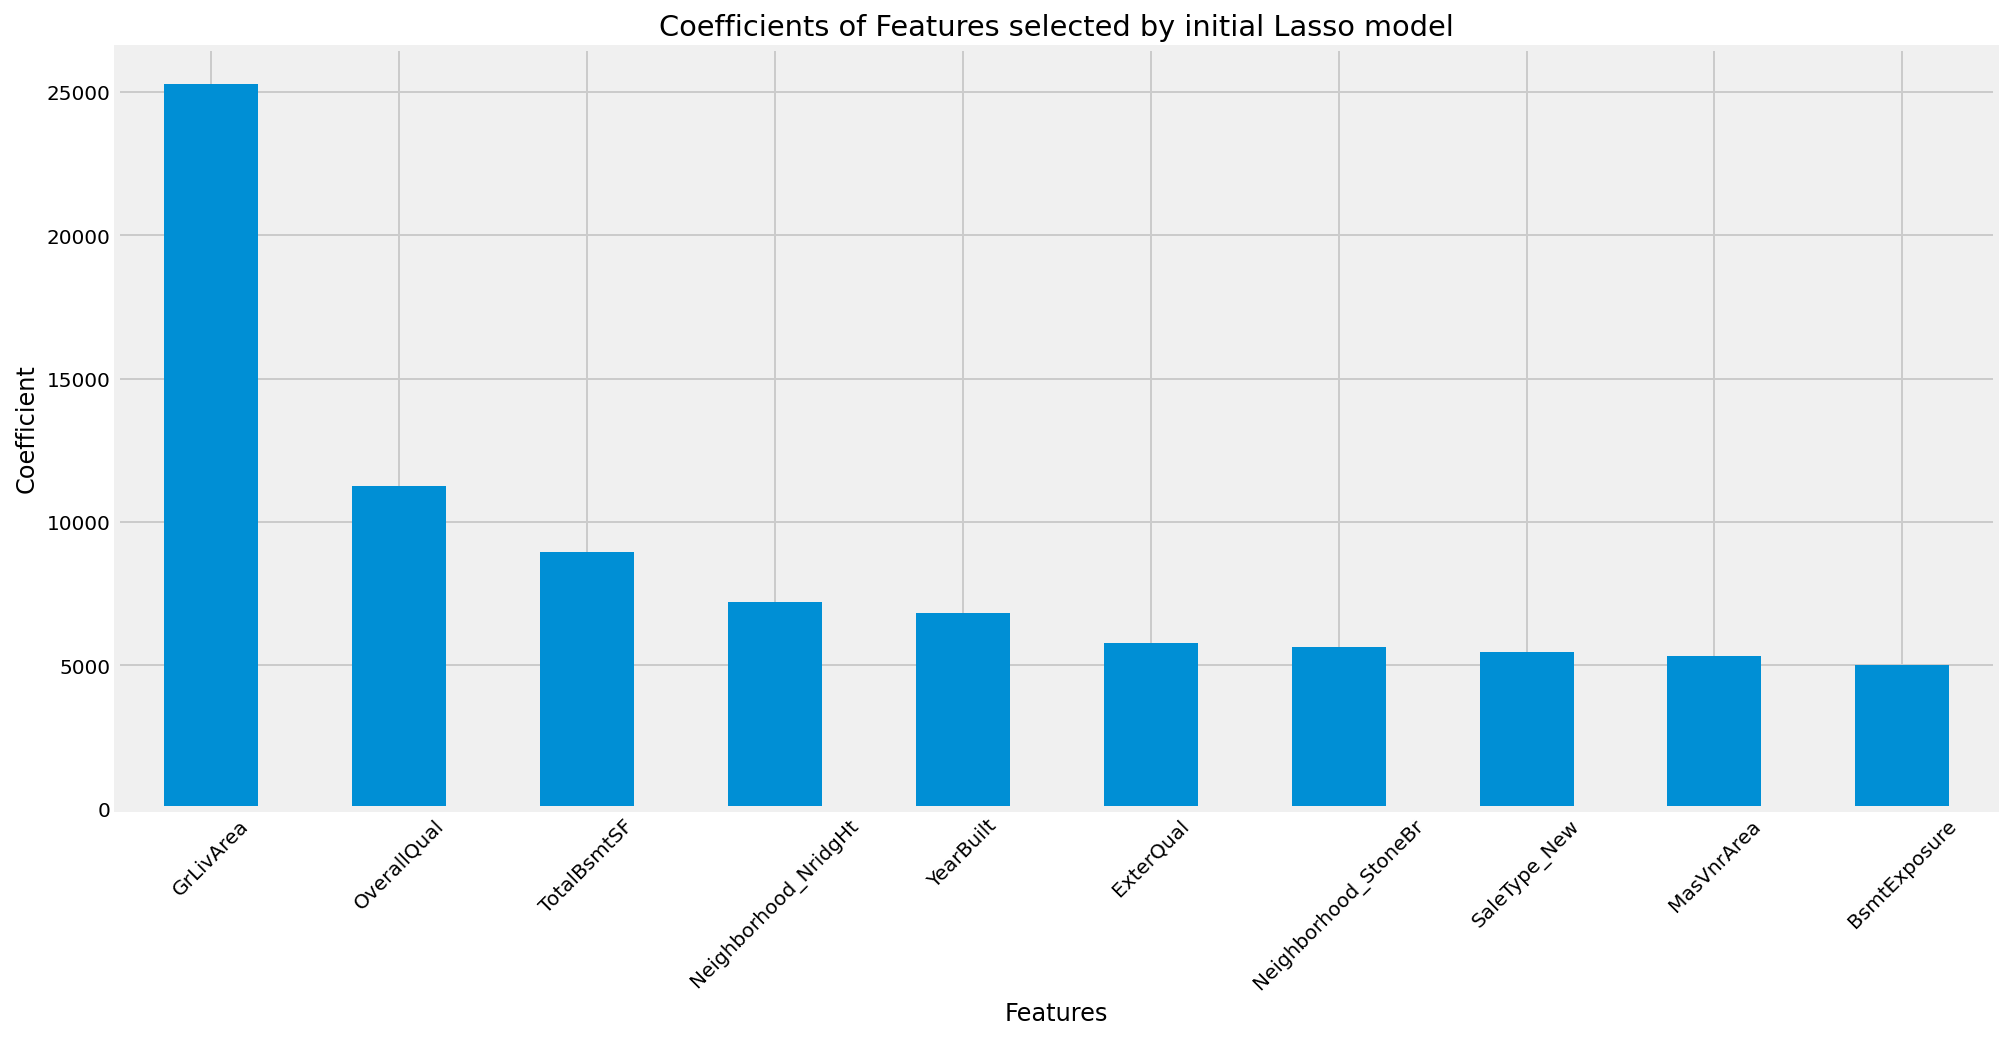

In [100]:
#For visualisation purposes
pd.Series(lasso_feat['abs_coef'].values, index=features_1).plot.bar(figsize=(15, 7))
plt.title('Coefficients of Features selected by initial Lasso model');
plt.xlabel('Features');
plt.ylabel('Coefficient');
plt.xticks(rotation=45);

**Next:** [Modelling](./02_Modelling.ipynb  )